
# Insurance Experiment Analysis 



In [58]:

from pathlib import Path
import json

# Auto-pick the newest results subdir; override manually if needed.
base_dir = Path("results")
subdirs = sorted([d for d in base_dir.glob("*") if d.is_dir()])
if not subdirs:
    raise FileNotFoundError("No subdirectories found under ./results. Run your experiment script first.")
results_dir = subdirs[-1]
print("Using results directory:", results_dir)

# Manual override example:
#results_dir = Path("results/2025_08_11_025610_(500ep_1000h_8-25d_4k_0.05e_0.00a_1.00g)")


Using results directory: results/2025_08_11_154559_(500ep_500h_8-25d_4k_0.05e_0.00a_1.00g)


In [59]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 140)

summary_df = pd.read_csv(results_dir / "experiment_summary.csv")
with open(results_dir / "run_meta.json", "r") as f:
    meta = json.load(f)
print("Summary rows:", summary_df.shape[0])
meta


Summary rows: 15000


{'git_commit': '8d46ef0029f32c7bc0ede2a4caa5dd81f2a892c3',
 'episodes': 500,
 'horizon': 500,
 'min_delay': 8,
 'max_delay': 25,
 'k_repeat': 4,
 'eps': 0.05,
 'alpha': 0.0004,
 'gamma': 0.999,
 'seeds': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 'scaling': 1}

In [60]:

# Load per-run CSVs
def parse_variant_seed(p: Path):
    name = p.stem
    parts = name.split("_")
    # try last two tokens
    variant = parts[-2]
    seed = int(parts[-1])
    return variant, seed

train_files = sorted(results_dir.glob("train_metrics_*_*.csv"))
eval_files = sorted(results_dir.glob("eval_metrics_*_*.csv"))

train_list = []
for p in train_files:
    df = pd.read_csv(p)
    v, s = parse_variant_seed(p)
    df["variant"] = df.get("variant", v)
    df["seed"] = df.get("seed", s)
    for col in ["ez_steps","ez_phases","ez_repeats","exploration_steps","exploration_rate"]:
        if col not in df.columns:
            df[col] = 0
    train_list.append(df)
train_df = pd.concat(train_list, ignore_index=True) if train_list else pd.DataFrame()

eval_list = []
for p in eval_files:
    df = pd.read_csv(p)
    v, s = parse_variant_seed(p)
    df["variant"] = df.get("variant", v)
    df["seed"] = df.get("seed", s)
    eval_list.append(df)
eval_df = pd.concat(eval_list, ignore_index=True) if eval_list else pd.DataFrame()

train_df.head(), (None if eval_df.empty else eval_df.head())


(    variant  seed  episode         return  steps  accept_rate  avg_premium  loss_paid_sum  min_capital  final_capital  bankrupt  \
 0  Annealed    10        1   84313.835965    500        0.810   380.870128  -68095.726712      50000.0  134313.835965         0   
 1  Annealed    10        2  108266.889793    500        0.788   389.488330  -44280.915527      50000.0  158266.889793         0   
 2  Annealed    10        3  115229.589654    500        0.790   382.226841  -35016.778004      50000.0  165229.589654         0   
 3  Annealed    10        4   93142.334330    500        0.798   382.392986  -56175.034229      50000.0  143142.334330         0   
 4  Annealed    10        5   85161.218151    500        0.800   383.619005  -67131.632816      50000.0  135161.218151         0   
 
    time_to_ruin  ez_steps  ez_phases  ez_repeats  exploration_steps  exploration_rate  
 0            -1         0          0           0                500             1.000  
 1            -1         0  

In [61]:

# Robust helpers
from typing import List, Tuple, Optional

def moving_average_full_length(a, k=20):
    """Moving average, returns same length as input (left padded with NaN)."""
    if k <= 1:
        return np.asarray(a, dtype=float)
    a = np.asarray(a, dtype=float)
    if len(a) == 0:
        return a
    if len(a) < k:
        # not enough points: return all-NaN except last valid mean if len>=1
        pad = np.full(len(a), np.nan)
        return pad
    ret = np.cumsum(np.insert(a, 0, 0.0))
    out = (ret[k:] - ret[:-k]) / float(k)
    pad_left = np.full(k-1, np.nan)
    return np.concatenate([pad_left, out])

def prepare_variant_series(g: pd.DataFrame, value_col: str, ma_k: Optional[int]=None) -> Tuple[np.ndarray, List[np.ndarray]]:
    """
    For one variant group g:
      - split by seed
      - sort by episode
      - optionally apply MA keeping full length (NaN padded)
      - align all seeds by the minimum available length
      - drop leading NaNs (from MA) consistently across seeds
      - return common x (1..L) and list of y arrays of length L
    """
    series = []
    min_len = None
    for s, gs in g.groupby("seed"):
        gs = gs.sort_values("episode")
        y = gs[value_col].to_numpy()
        if ma_k is not None:
            y = moving_average_full_length(y, k=ma_k)
        if min_len is None or len(y) < min_len:
            min_len = len(y)
        series.append(y)
    if min_len is None or min_len == 0:
        return np.array([]), []
    # Trim all to min_len
    series = [y[:min_len] for y in series]
    # Determine first index where all seeds have non-NaN (avoid MA padding mismatch)
    mask_valid = ~np.any(np.isnan(np.vstack(series)), axis=0)
    if not np.any(mask_valid):
        # if everything NaN (e.g., too short), just return zeros to avoid crashes
        L = min_len
        x = np.arange(1, L+1)
        series = [np.zeros(L) for _ in series]
        return x, series
    # keep only valid columns
    series = [y[mask_valid] for y in series]
    L = series[0].shape[0]
    x = np.arange(1, L+1)
    return x, series

def plot_mean_std(ax, x, ys, label=None):
    if not ys:
        return
    Y = np.vstack(ys)
    mu = np.nanmean(Y, axis=0)
    sd = np.nanstd(Y, axis=0)
    ax.plot(x, mu, label=label)
    ax.fill_between(x, mu - sd, mu + sd, alpha=0.2)


## Training: Return per Episode

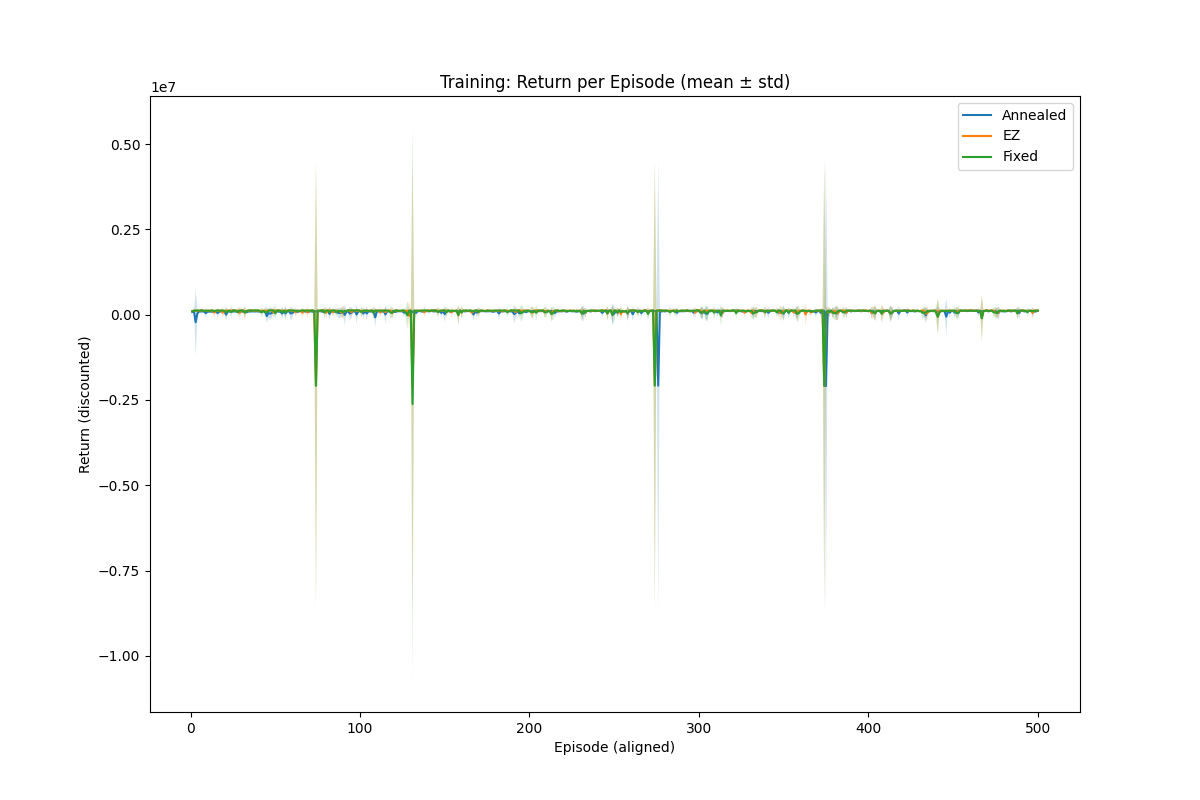

In [62]:
%matplotlib widget
if train_df.empty:
    print("No training metrics found.")
else:
    fig = plt.figure(figsize=(12,8))
    ax = plt.gca()
    for v, g in train_df.groupby("variant"):
        x, ys = prepare_variant_series(g, value_col="return", ma_k=None)
        if len(x) > 0:
            plot_mean_std(ax, x, ys, label=v)
    ax.set_xlabel("Episode (aligned)")
    ax.set_ylabel("Return (discounted)")
    ax.set_title("Training: Return per Episode (mean ± std)")
    ax.legend()
    plt.show()


## Acceptance rate over training 

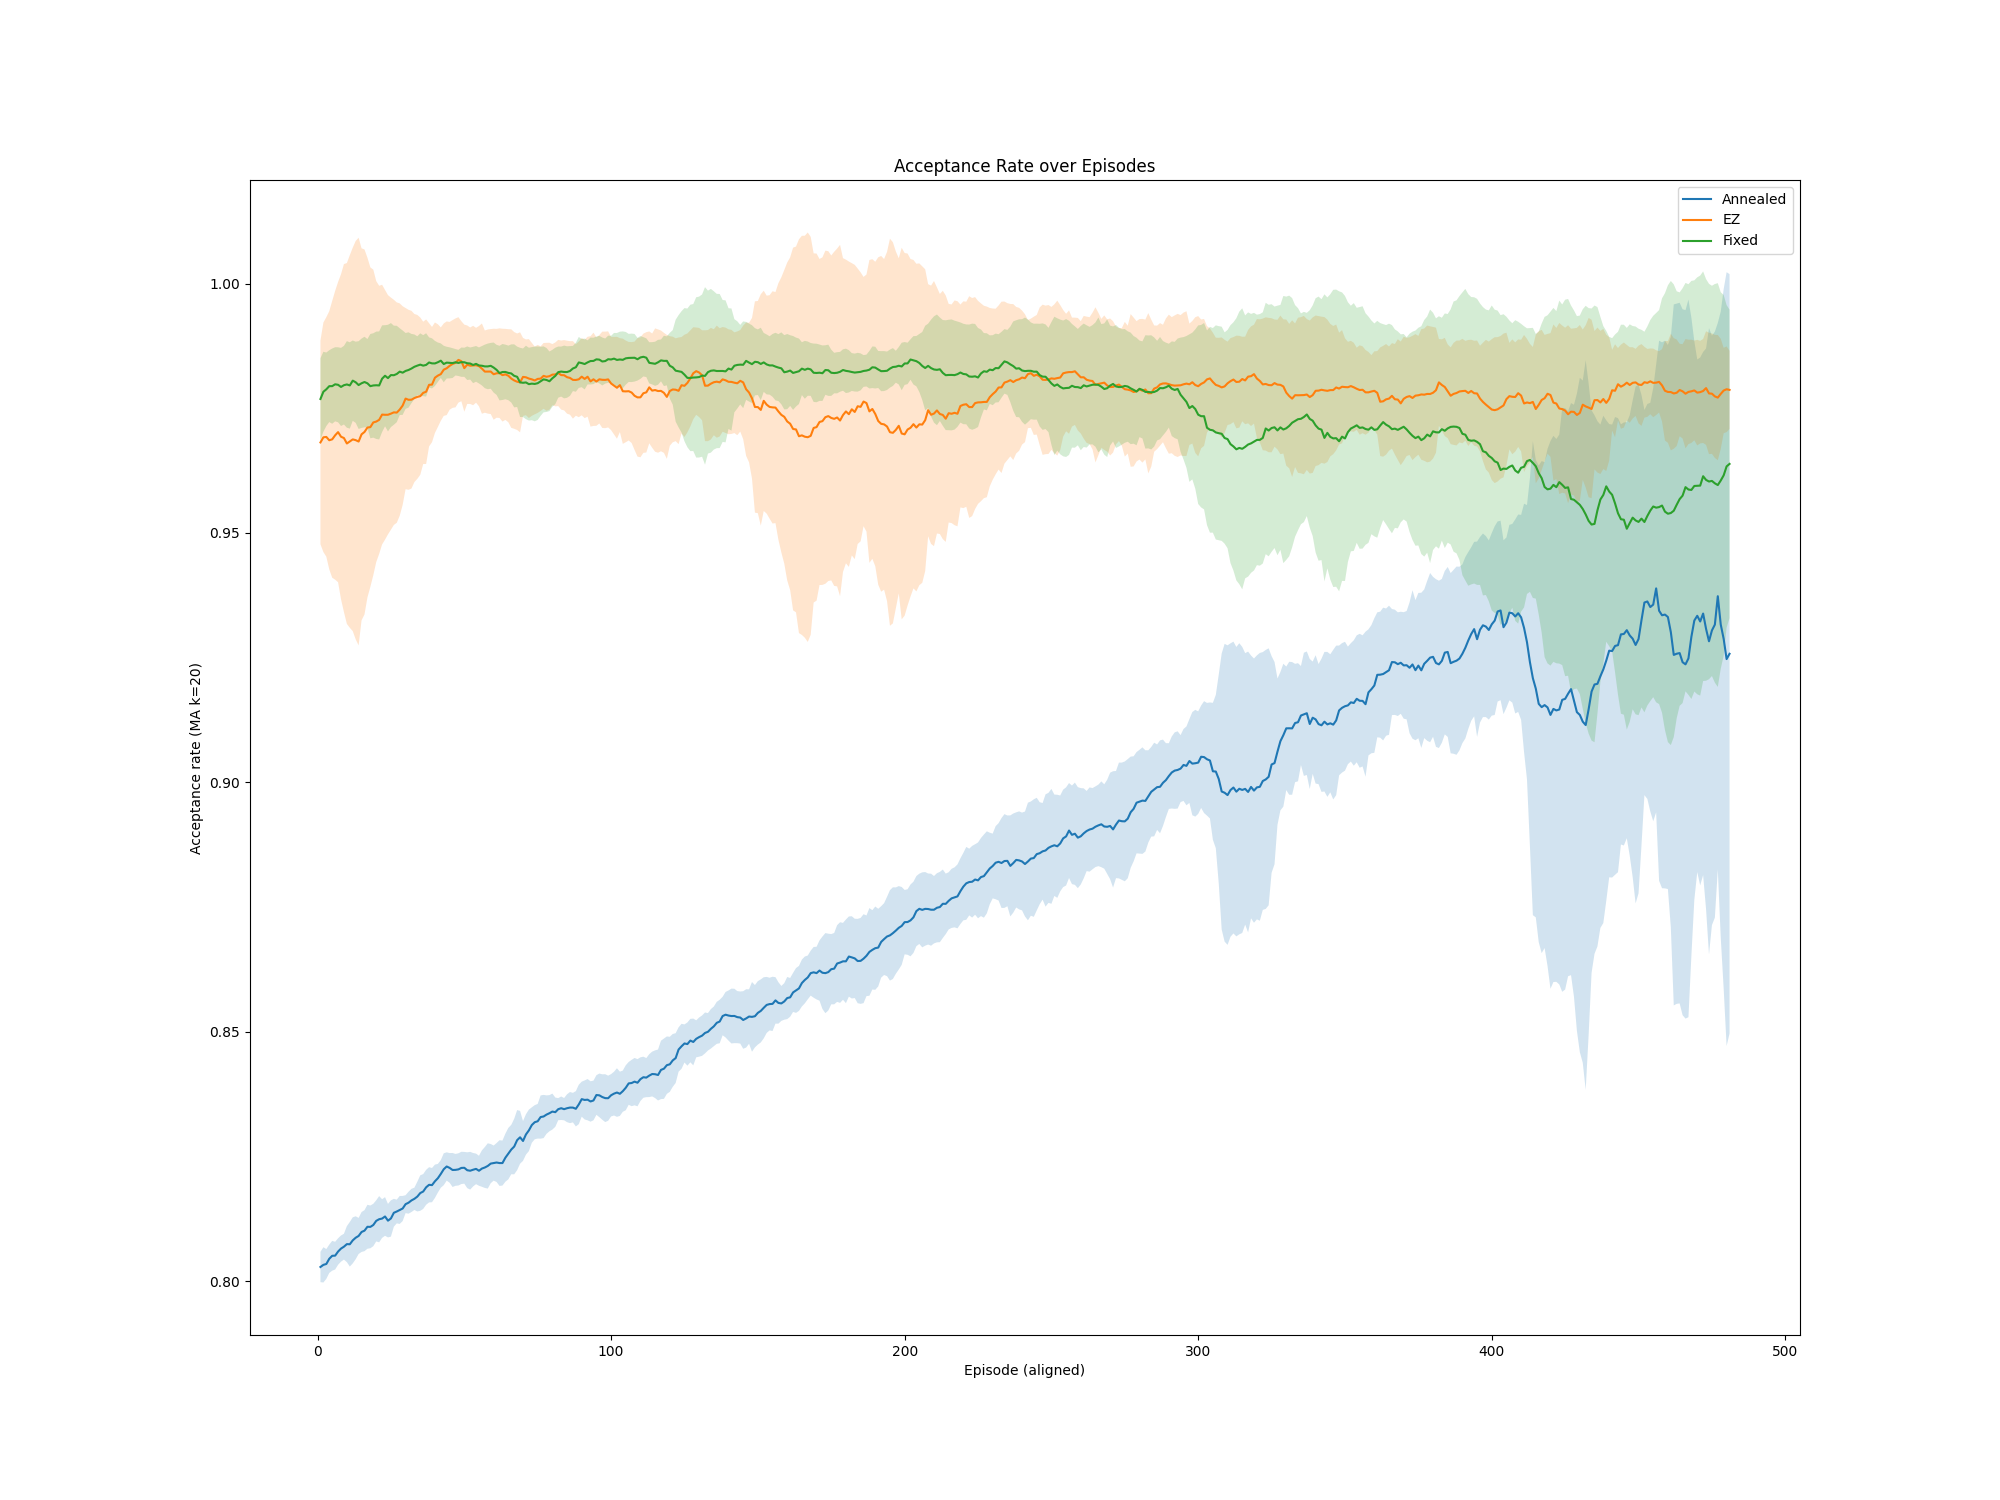

In [63]:

if train_df.empty:
    print("No training metrics found.")
else:
    fig = plt.figure(figsize=(20,15))
    ax = plt.gca()
    for v, g in train_df.groupby("variant"):
        x, ys = prepare_variant_series(g, value_col="accept_rate", ma_k=20)
        if len(x) > 0 and ys:
            plot_mean_std(ax, x, ys, label=v)
    ax.set_xlabel("Episode (aligned)")
    ax.set_ylabel("Acceptance rate (MA k=20)")
    ax.set_title("Acceptance Rate over Episodes")
    ax.legend()
    plt.show()


## Average premium of accepted policies 

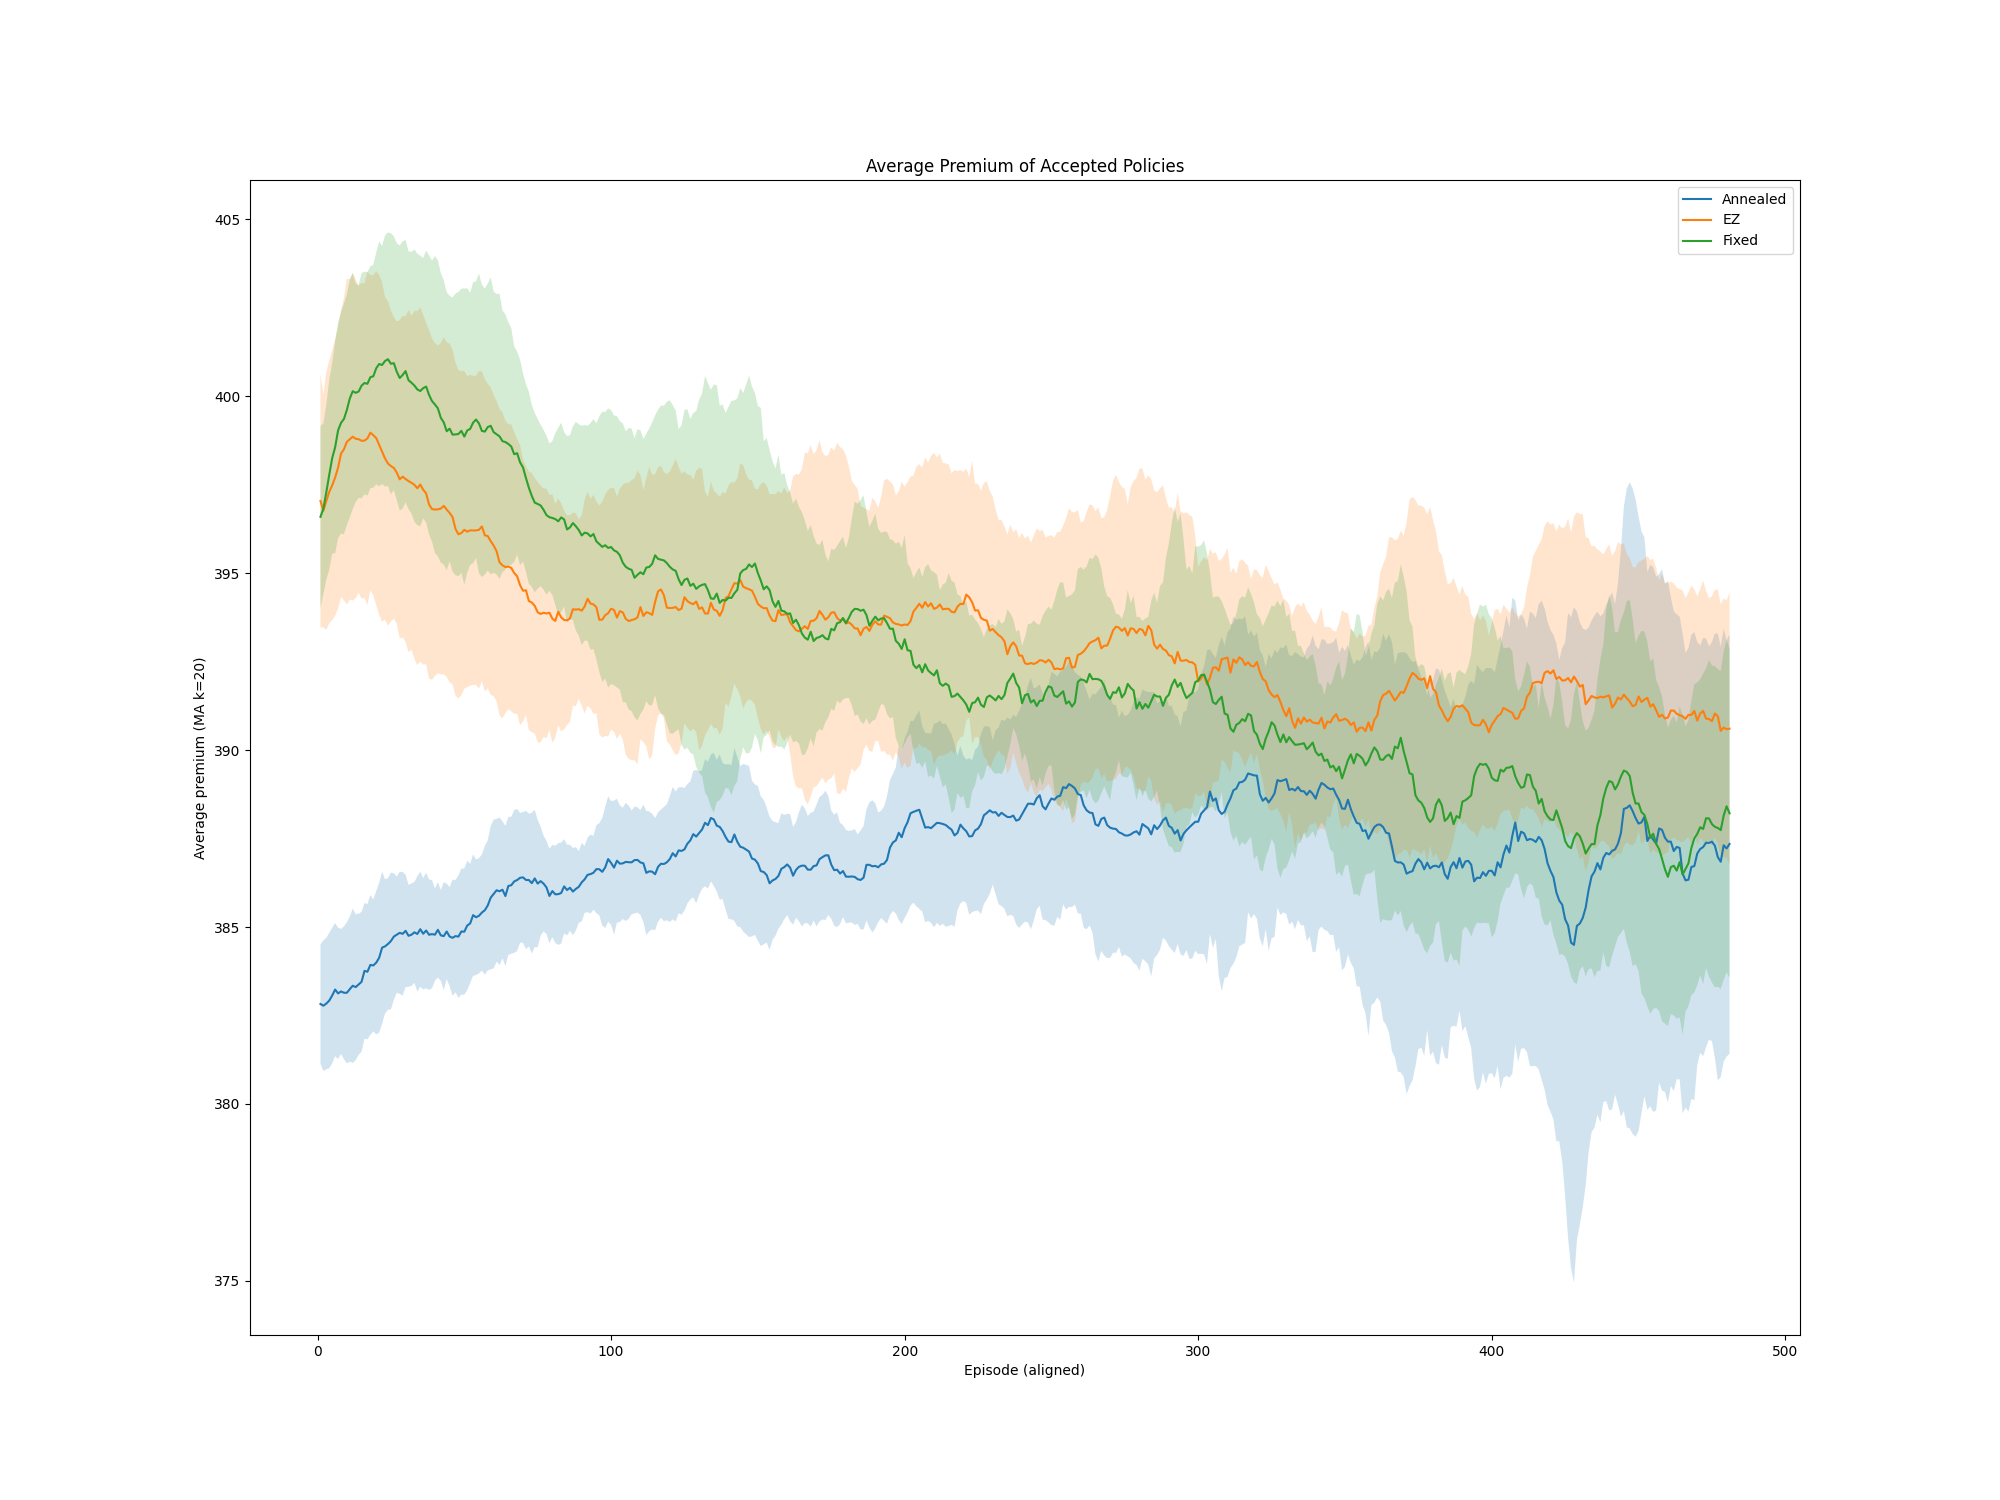

In [64]:

if train_df.empty:
    print("No training metrics found.")
else:
    fig = plt.figure(figsize=(20,15))
    ax = plt.gca()
    for v, g in train_df.groupby("variant"):
        x, ys = prepare_variant_series(g, value_col="avg_premium", ma_k=20)
        if len(x) > 0 and ys:
            plot_mean_std(ax, x, ys, label=v)
    ax.set_xlabel("Episode (aligned)")
    ax.set_ylabel("Average premium (MA k=20)")
    ax.set_title("Average Premium of Accepted Policies")
    ax.legend()
    plt.show()


## Capital over episodes 

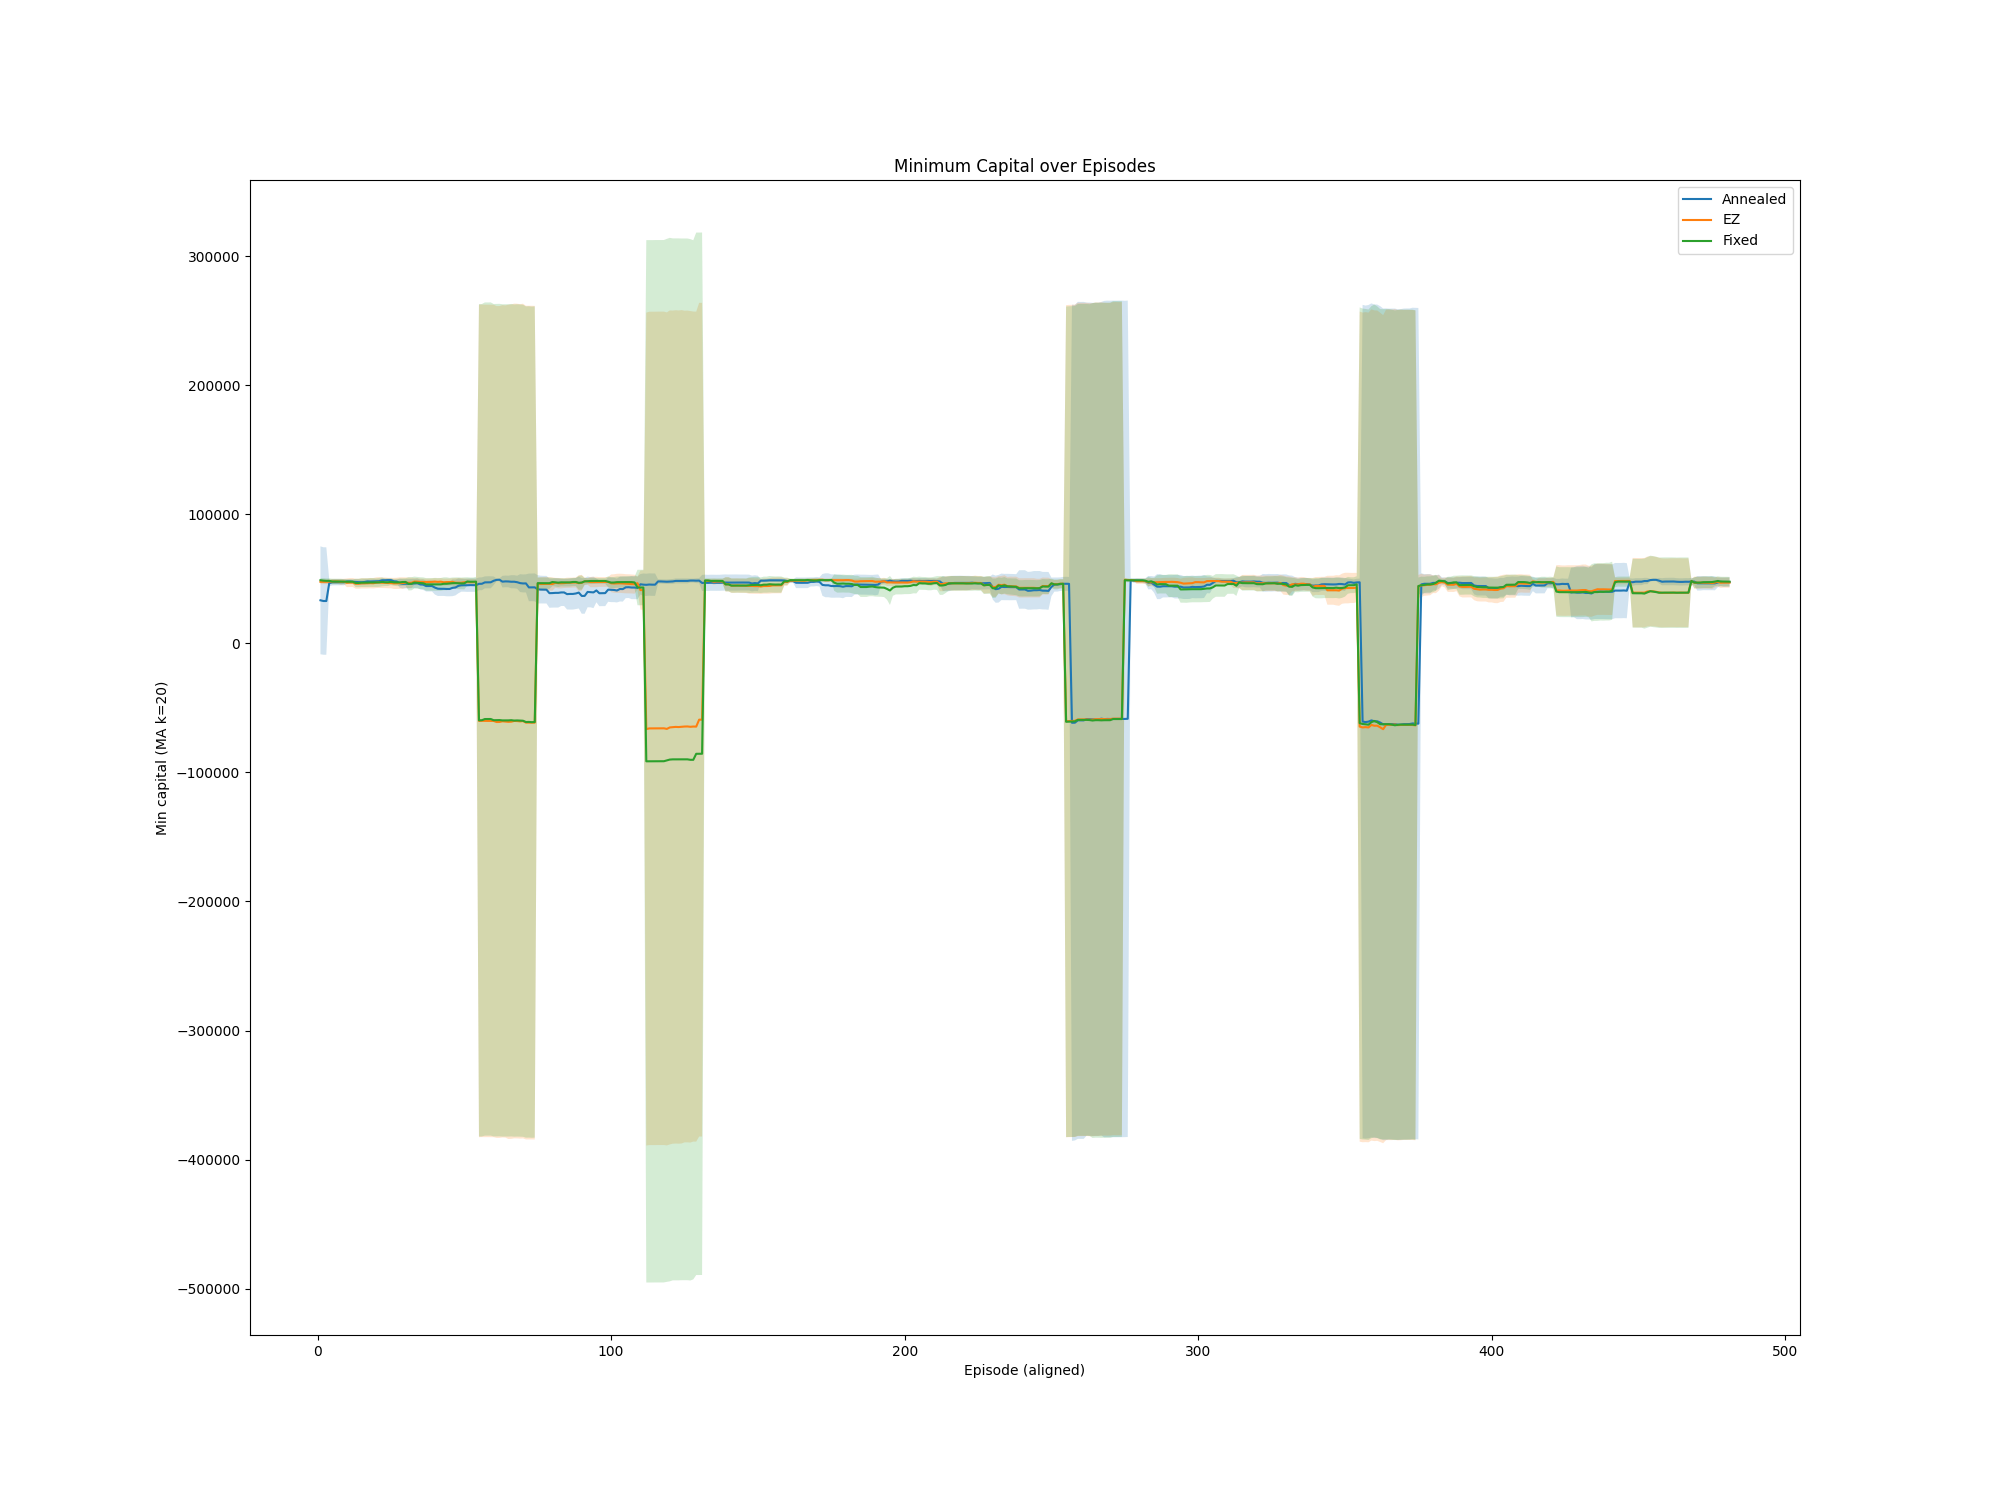

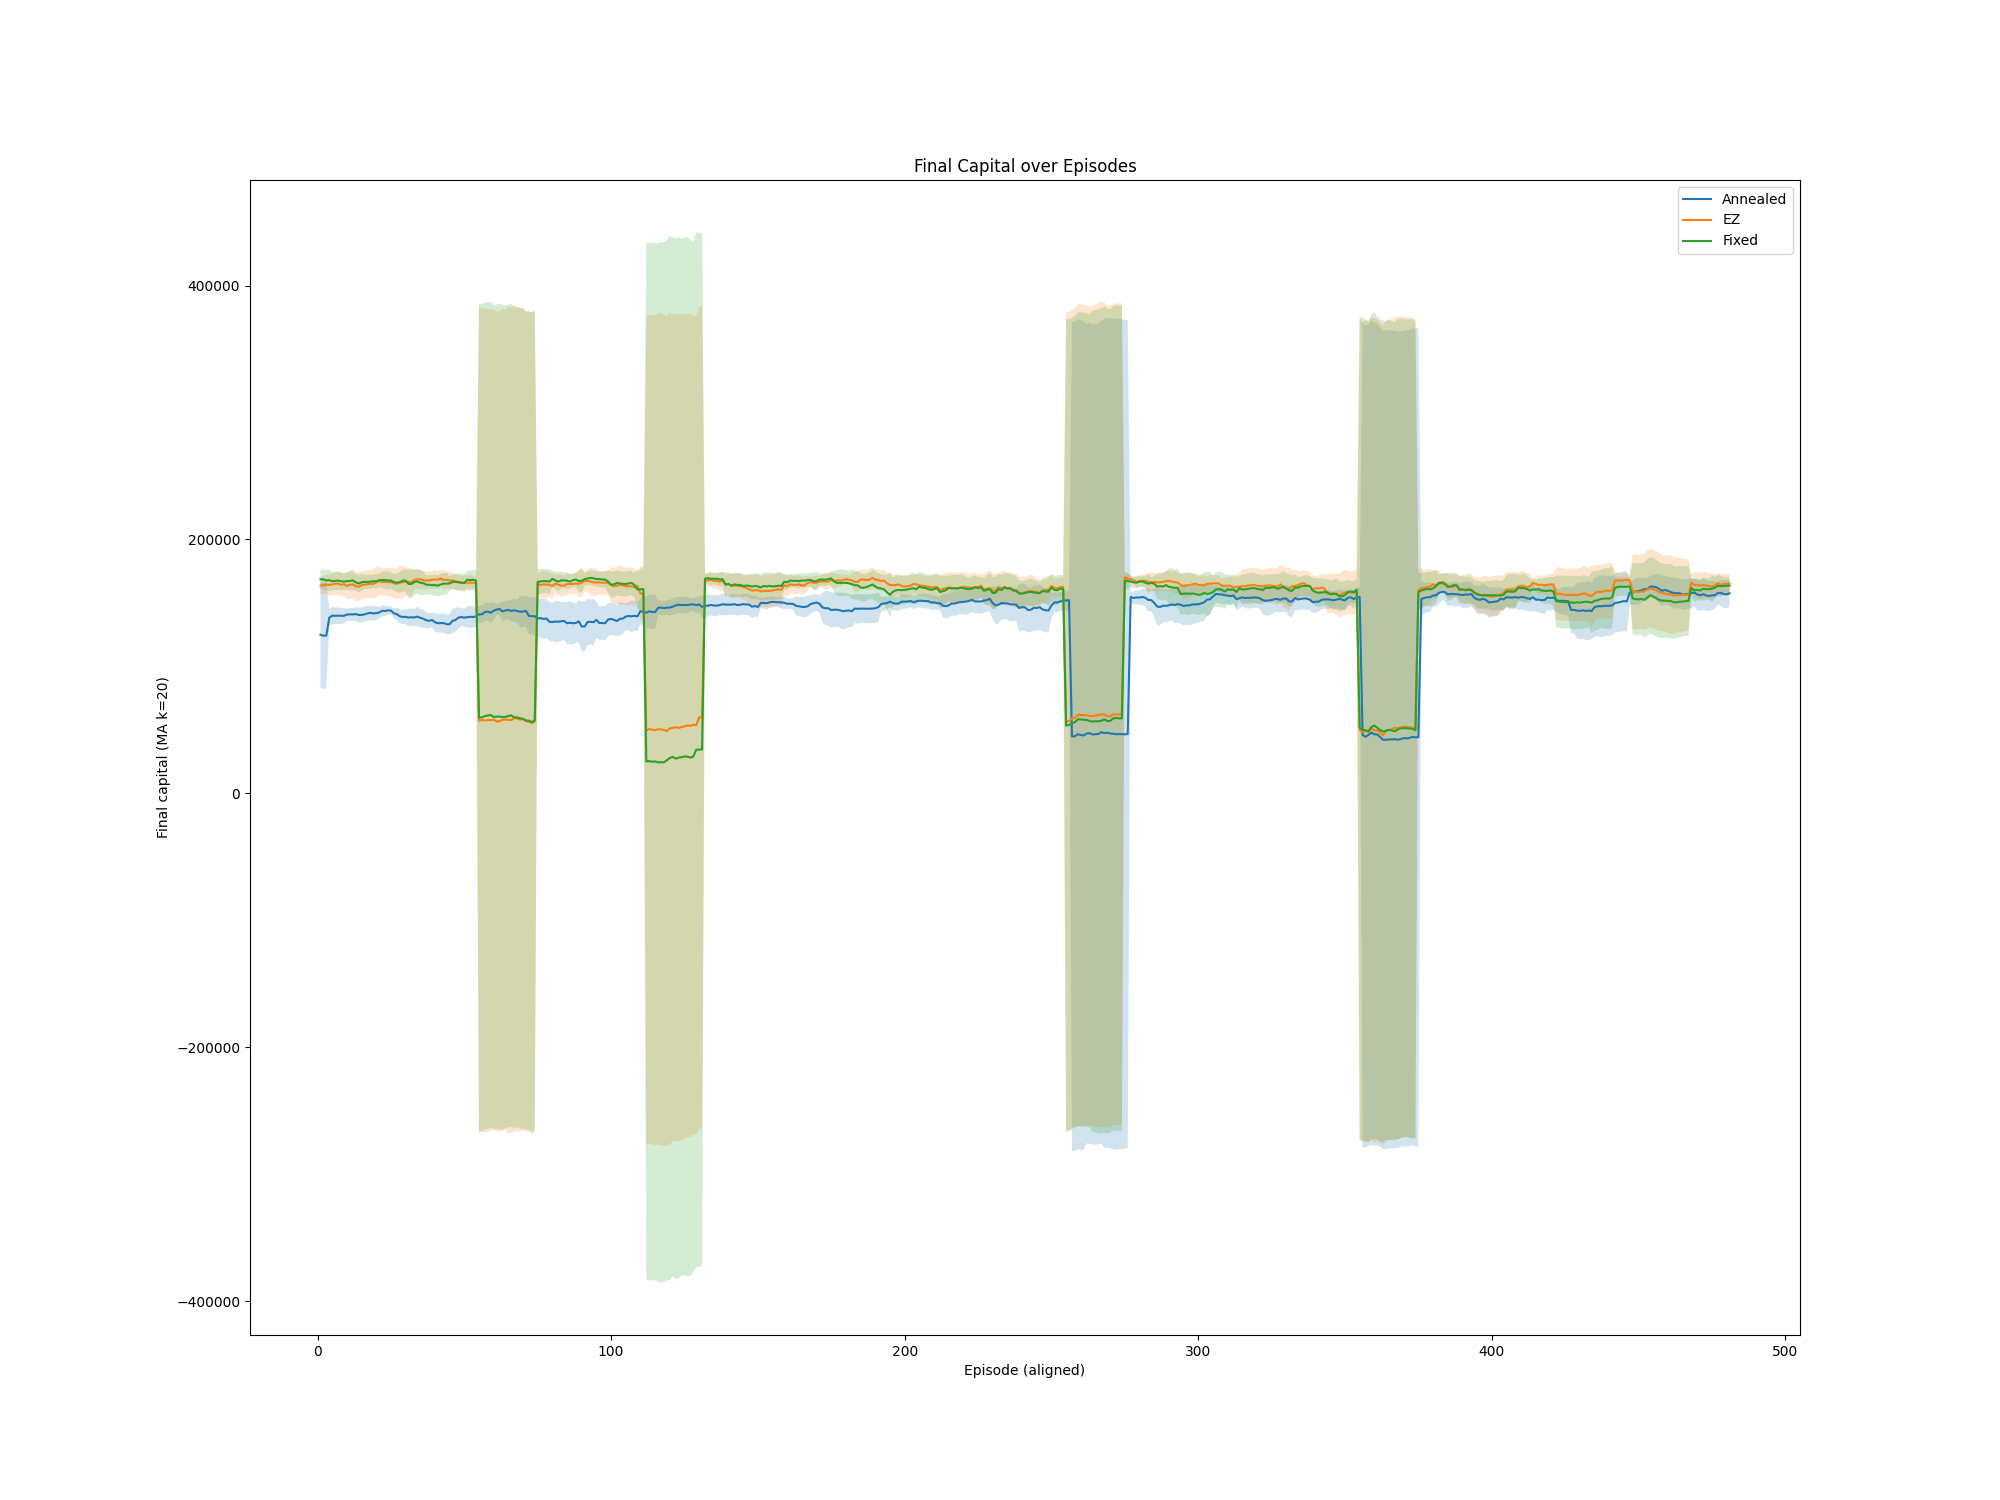

In [65]:

if train_df.empty:
    print("No training metrics found.")
else:
    # Min capital
    fig = plt.figure(figsize=(20,15))
    ax = plt.gca()
    for v, g in train_df.groupby("variant"):
        x, ys = prepare_variant_series(g, value_col="min_capital", ma_k=20)
        if len(x) > 0 and ys:
            plot_mean_std(ax, x, ys, label=v)
    ax.set_xlabel("Episode (aligned)")
    ax.set_ylabel("Min capital (MA k=20)")
    ax.set_title("Minimum Capital over Episodes")
    ax.legend()
    plt.show()

    # Final capital
    fig = plt.figure(figsize=(20,15))
    ax = plt.gca()
    for v, g in train_df.groupby("variant"):
        x, ys = prepare_variant_series(g, value_col="final_capital", ma_k=20)
        if len(x) > 0 and ys:
            plot_mean_std(ax, x, ys, label=v)
    ax.set_xlabel("Episode (aligned)")
    ax.set_ylabel("Final capital (MA k=20)")
    ax.set_title("Final Capital over Episodes")
    ax.legend()
    plt.show()


## Bankruptcy rate 

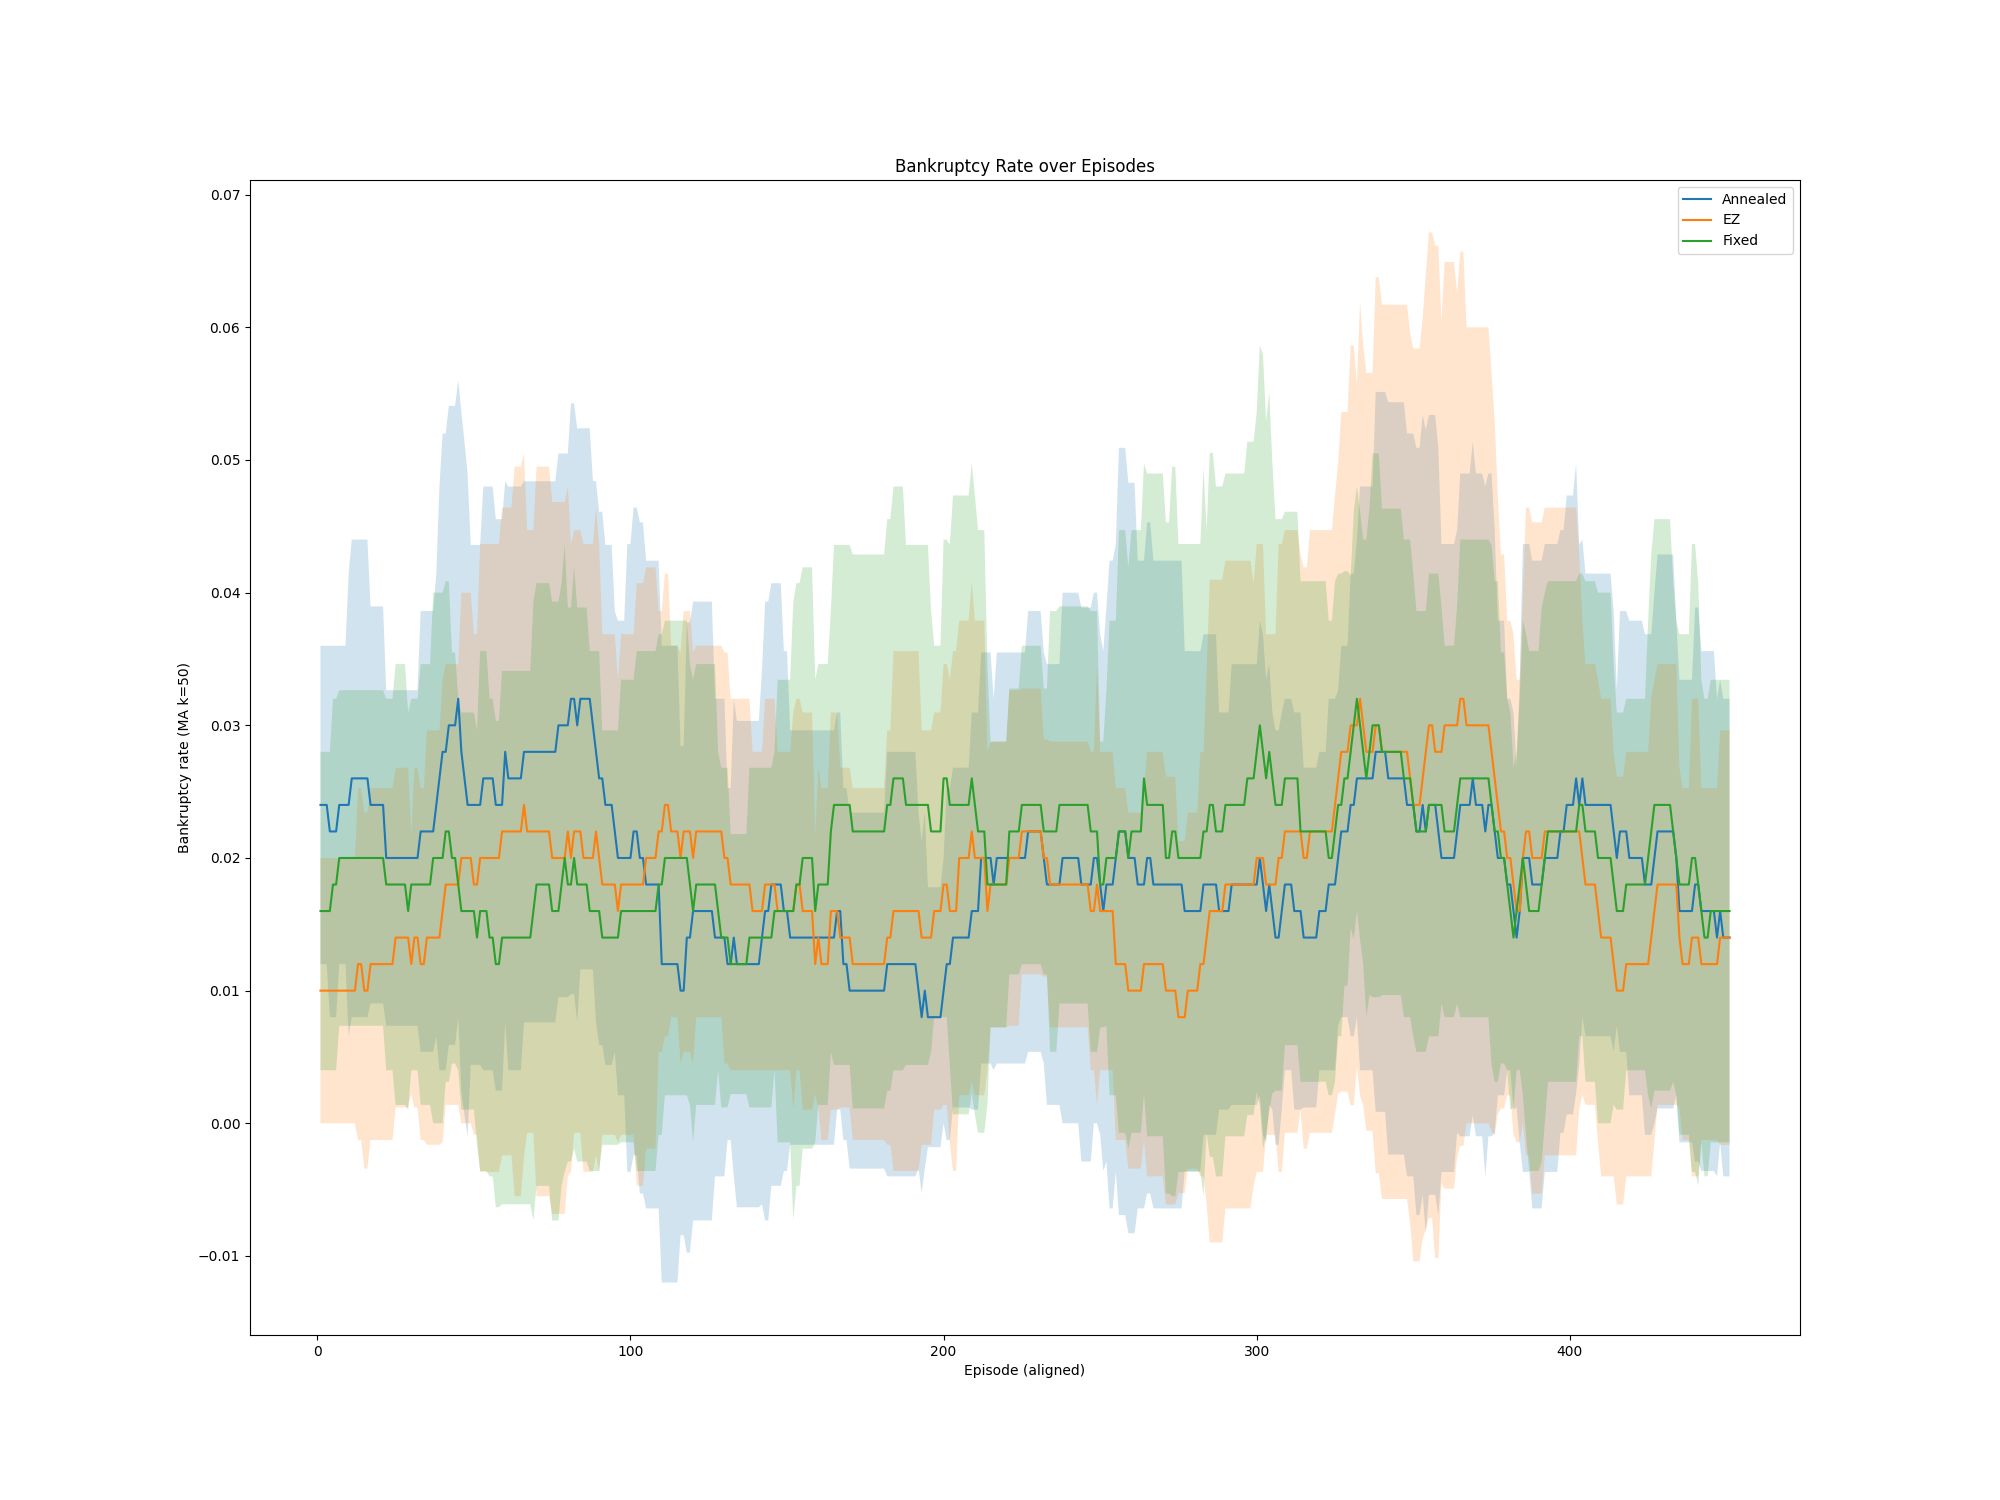

In [66]:

if train_df.empty:
    print("No training metrics found.")
else:
    fig = plt.figure(figsize=(20,15))
    ax = plt.gca()
    for v, g in train_df.groupby("variant"):
        x, ys = prepare_variant_series(g, value_col="bankrupt", ma_k=50)
        if len(x) > 0 and ys:
            # bankrupt is 0/1; MA makes it a rate
            plot_mean_std(ax, x, ys, label=v)
    ax.set_xlabel("Episode (aligned)")
    ax.set_ylabel("Bankruptcy rate (MA k=50)")
    ax.set_title("Bankruptcy Rate over Episodes")
    ax.legend()
    plt.show()


## Exploration dynamics 

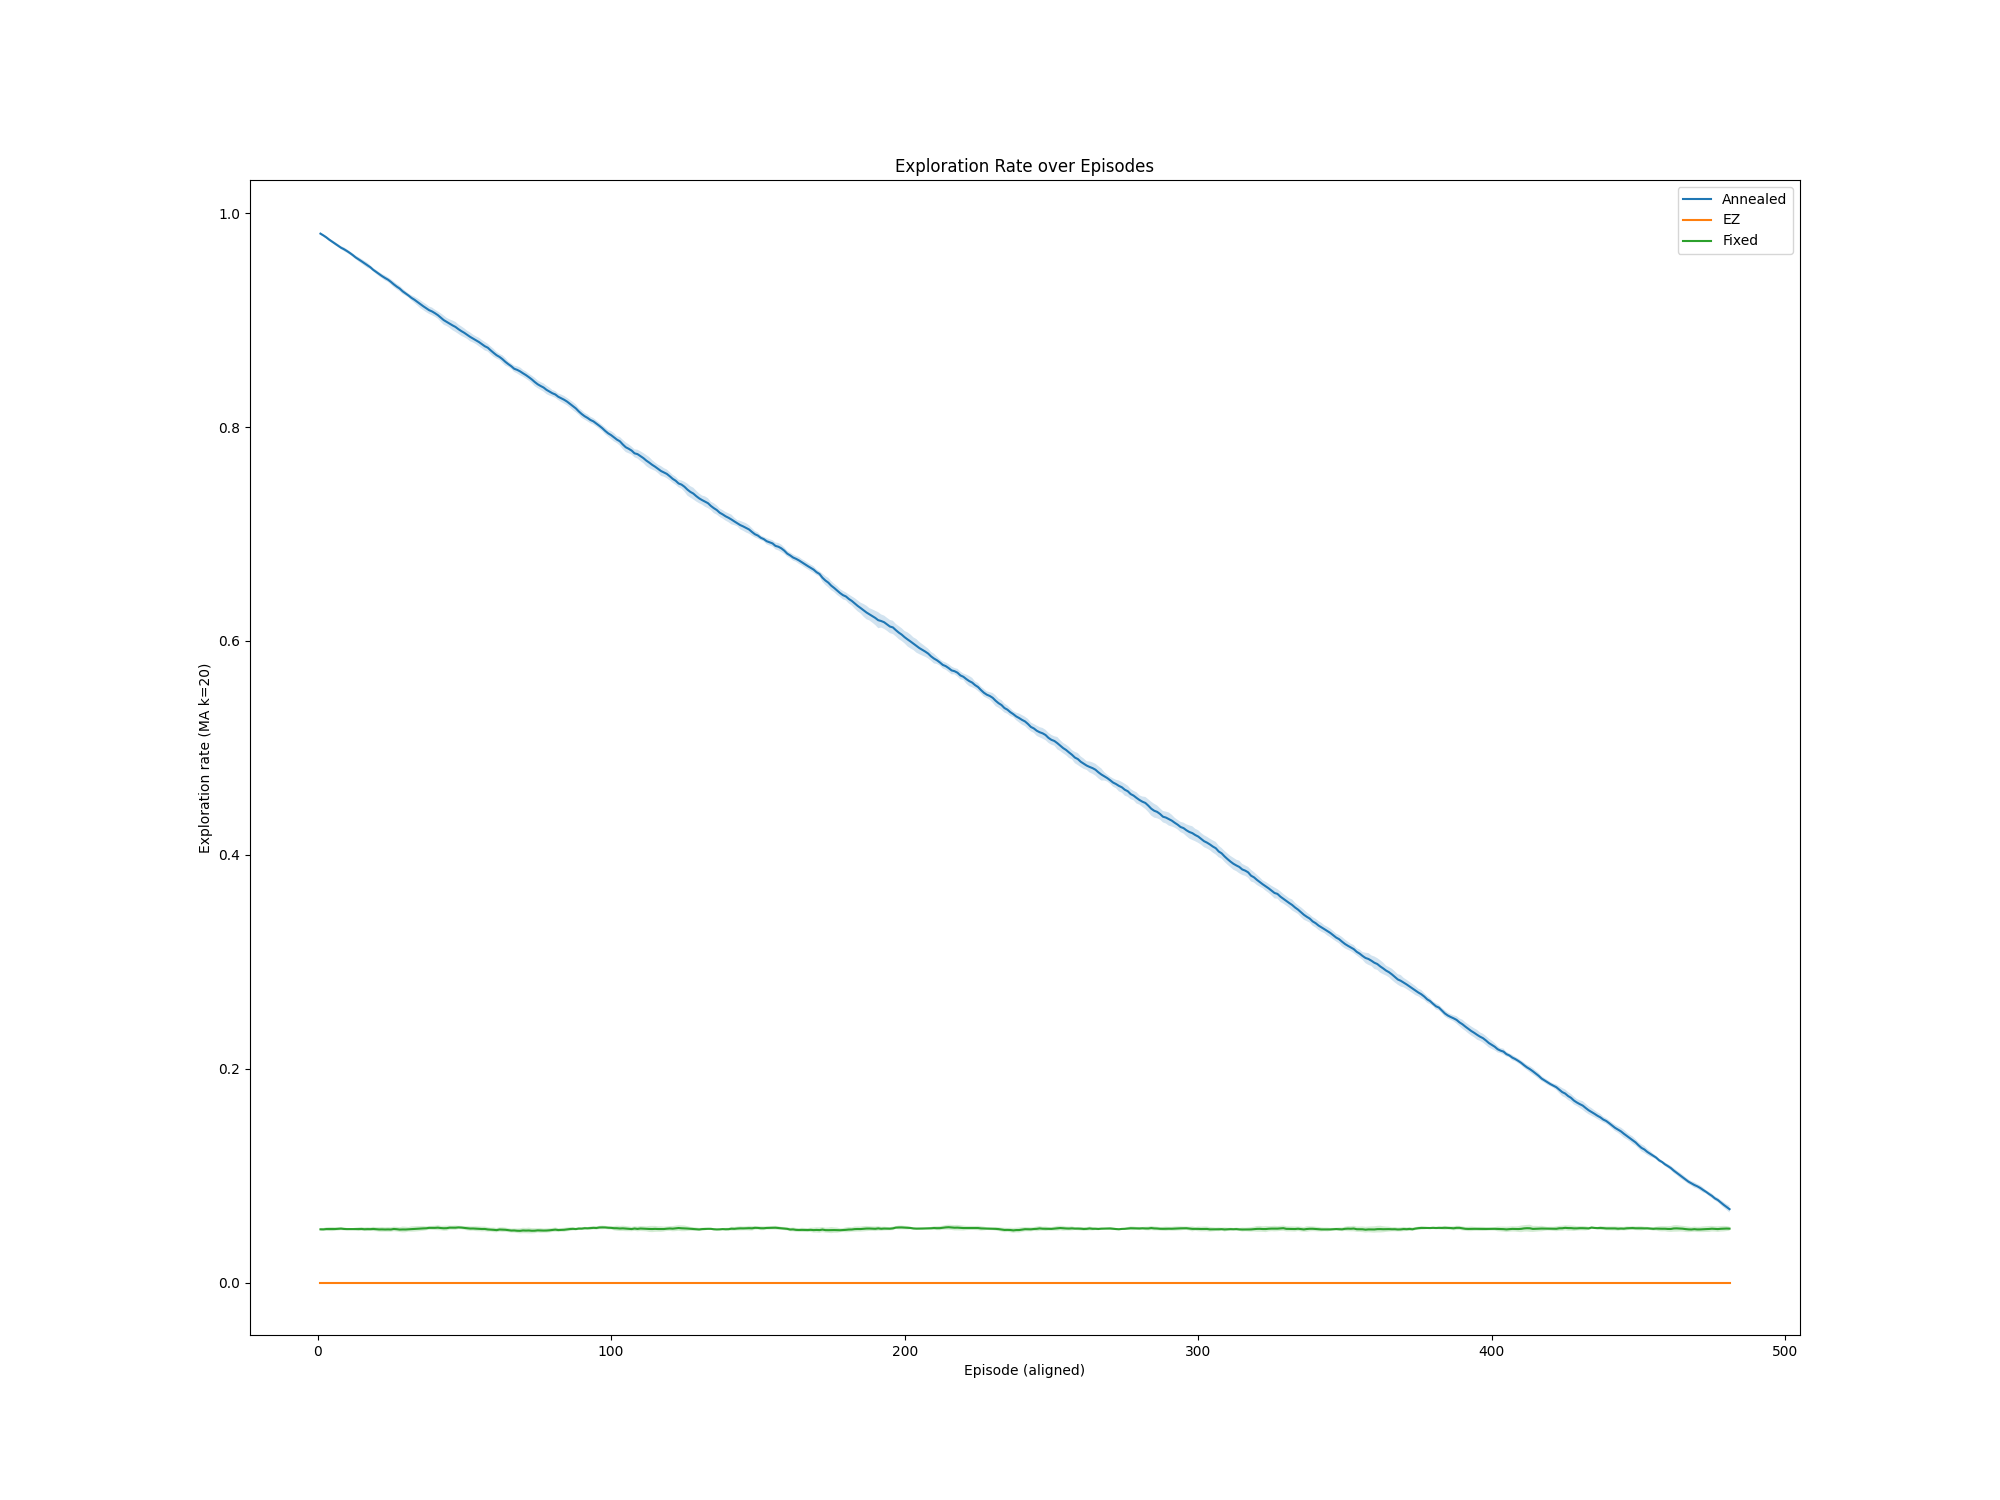

In [67]:

if train_df.empty or "exploration_rate" not in train_df.columns:
    print("No exploration metrics found.")
else:
    fig = plt.figure(figsize=(20,15))
    ax = plt.gca()
    for v, g in train_df.groupby("variant"):
        x, ys = prepare_variant_series(g, value_col="exploration_rate", ma_k=20)
        if len(x) > 0 and ys:
            plot_mean_std(ax, x, ys, label=v)
    ax.set_xlabel("Episode (aligned)")
    ax.set_ylabel("Exploration rate (MA k=20)")
    ax.set_title("Exploration Rate over Episodes")
    ax.legend()
    plt.show()


## EZ-Greedy details 

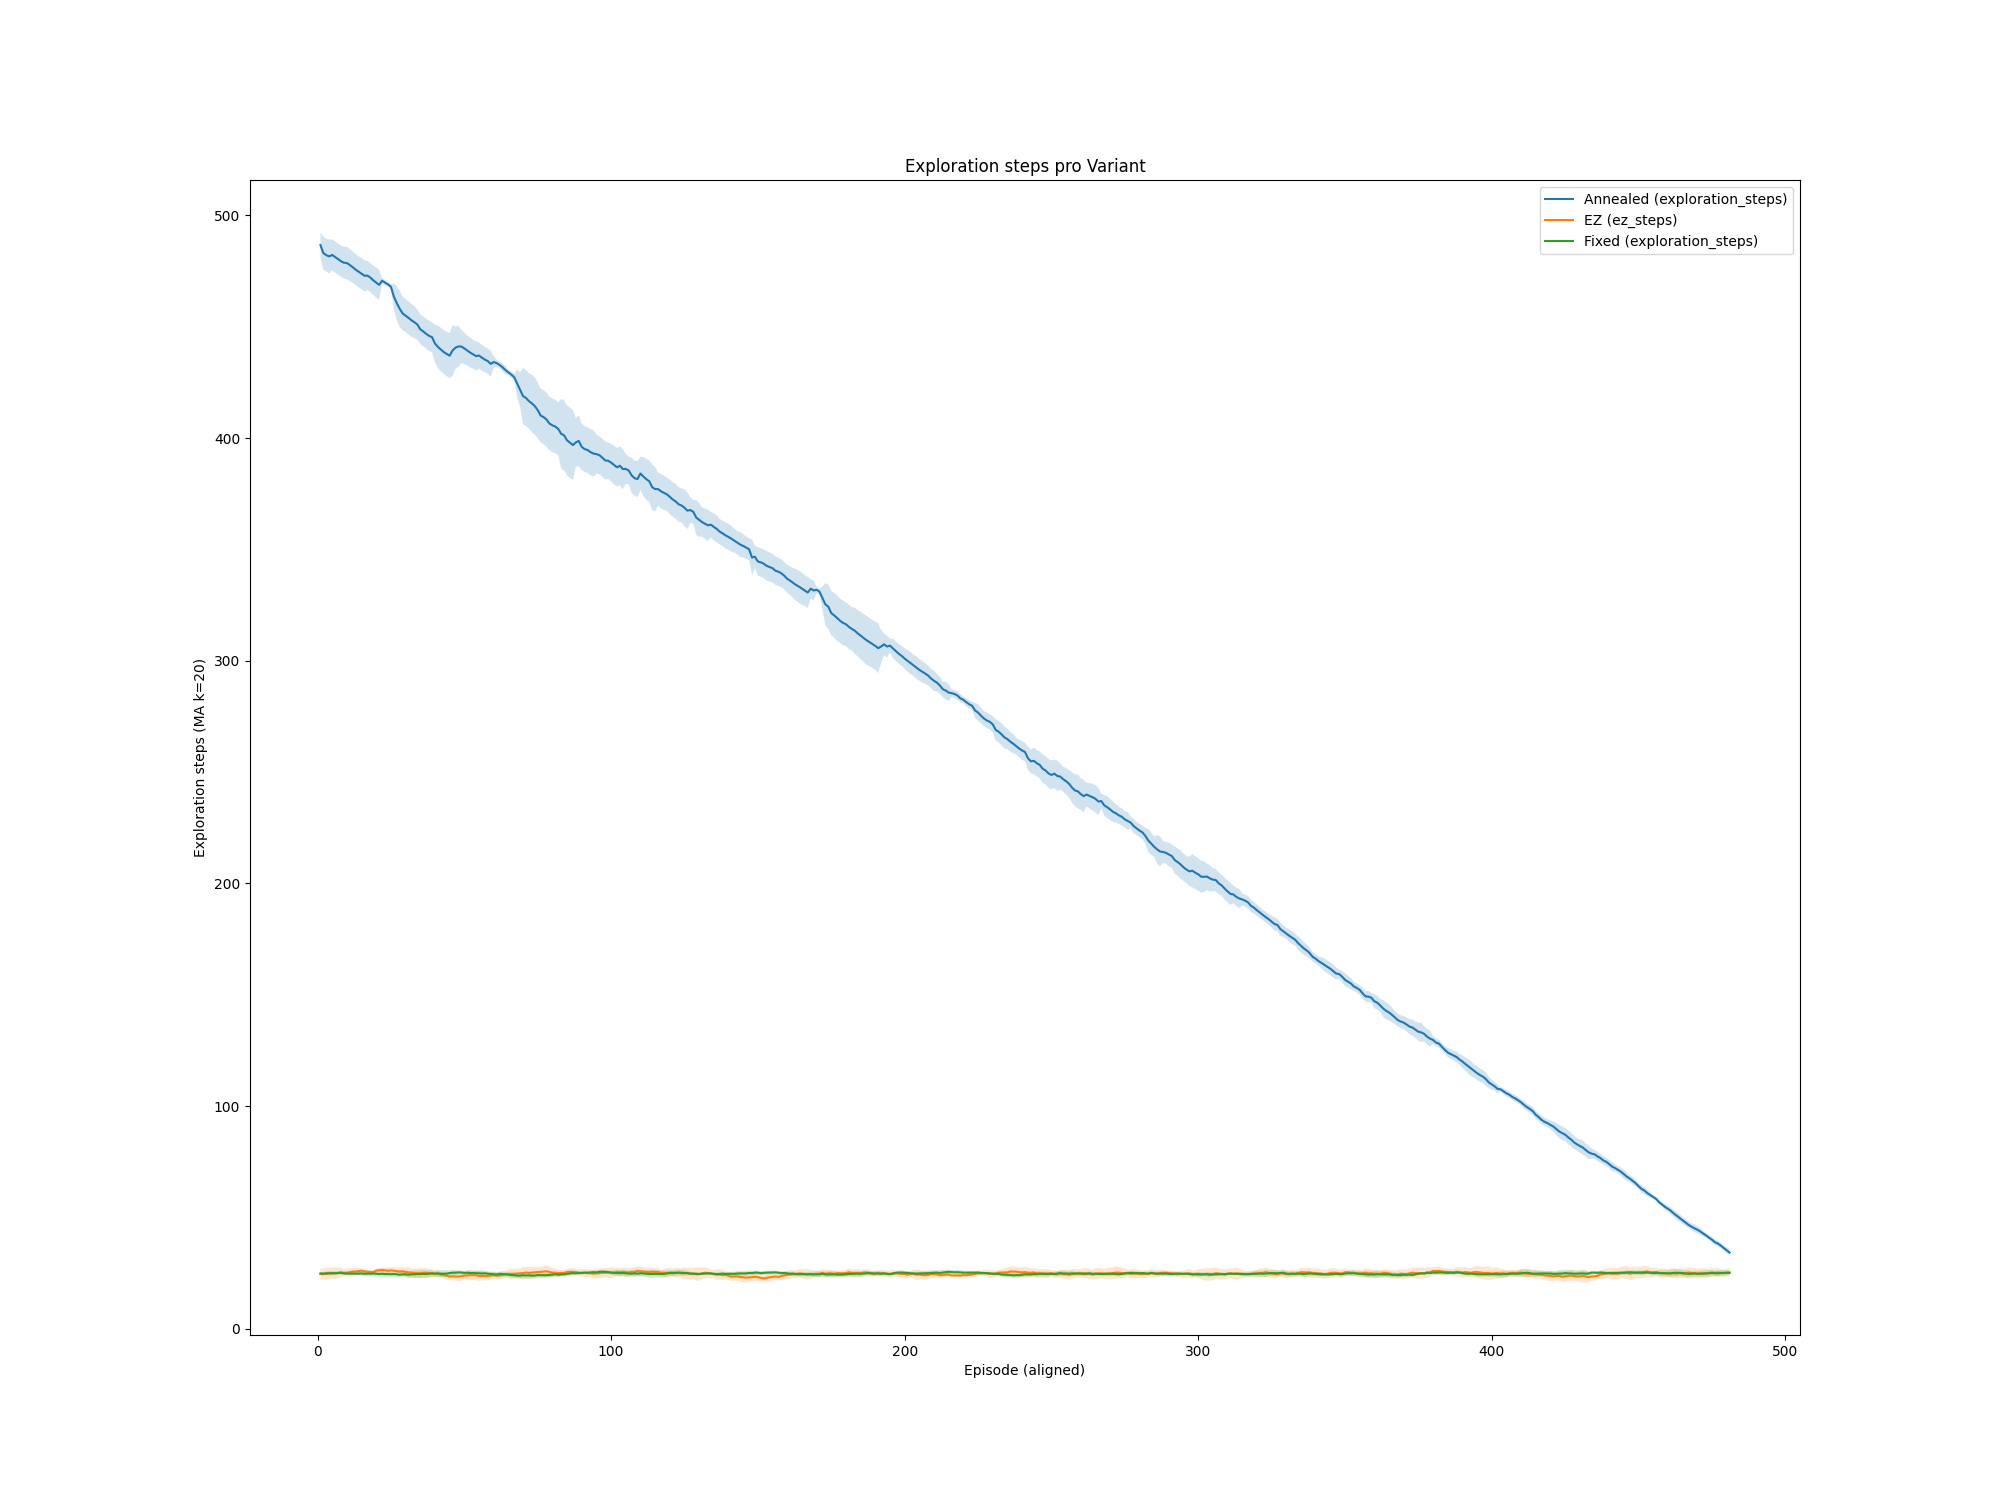

In [68]:

# if train_df.empty:
#     print("No training metrics found.")
# else:
#     for metric, title in [
#         ("ez_steps", "EZ: Exploratory Steps per Episode (MA k=20)"),
#         ("ez_phases", "EZ: Exploratory Phases per Episode (MA k=20)"),
#         ("ez_repeats", "EZ: Repeats per Episode (MA k=20)"),
#     ]:
#         fig = plt.figure(figsize=(20,15))
#         ax = plt.gca()
#         for v, g in train_df.groupby("variant"):
#             x, ys = prepare_variant_series(g, value_col=metric, ma_k=20)
#             if len(x) > 0 and ys:
#                 plot_mean_std(ax, x, ys, label=v)
#         ax.set_xlabel("Episode (aligned)")
#         ax.set_ylabel(metric + " (MA k=20)")
#         ax.set_title(title)
#         ax.legend()
#         plt.show()


if train_df.empty:
    print("No training metrics found.")
else:
    variant_metric_map = {
        "EZ": "ez_steps",
        "Annealed": "exploration_steps",
        "Fixed": "exploration_steps",
    }

    fig = plt.figure(figsize=(20, 15))
    ax = plt.gca()

    for v, g in train_df.groupby("variant"):
        if v in variant_metric_map:
            col = variant_metric_map[v]
            if col in g.columns and g[col].notna().any():
                x, ys = prepare_variant_series(g, value_col=col, ma_k=20)
                if len(x) > 0 and ys:
                    plot_mean_std(ax, x, ys, label=f"{v} ({col})")

    ax.set_xlabel("Episode (aligned)")
    ax.set_ylabel("Exploration steps (MA k=20)")
    ax.set_title("Exploration steps pro Variant")
    ax.legend()
    plt.show()



## Evaluation blocks (greedy policy)

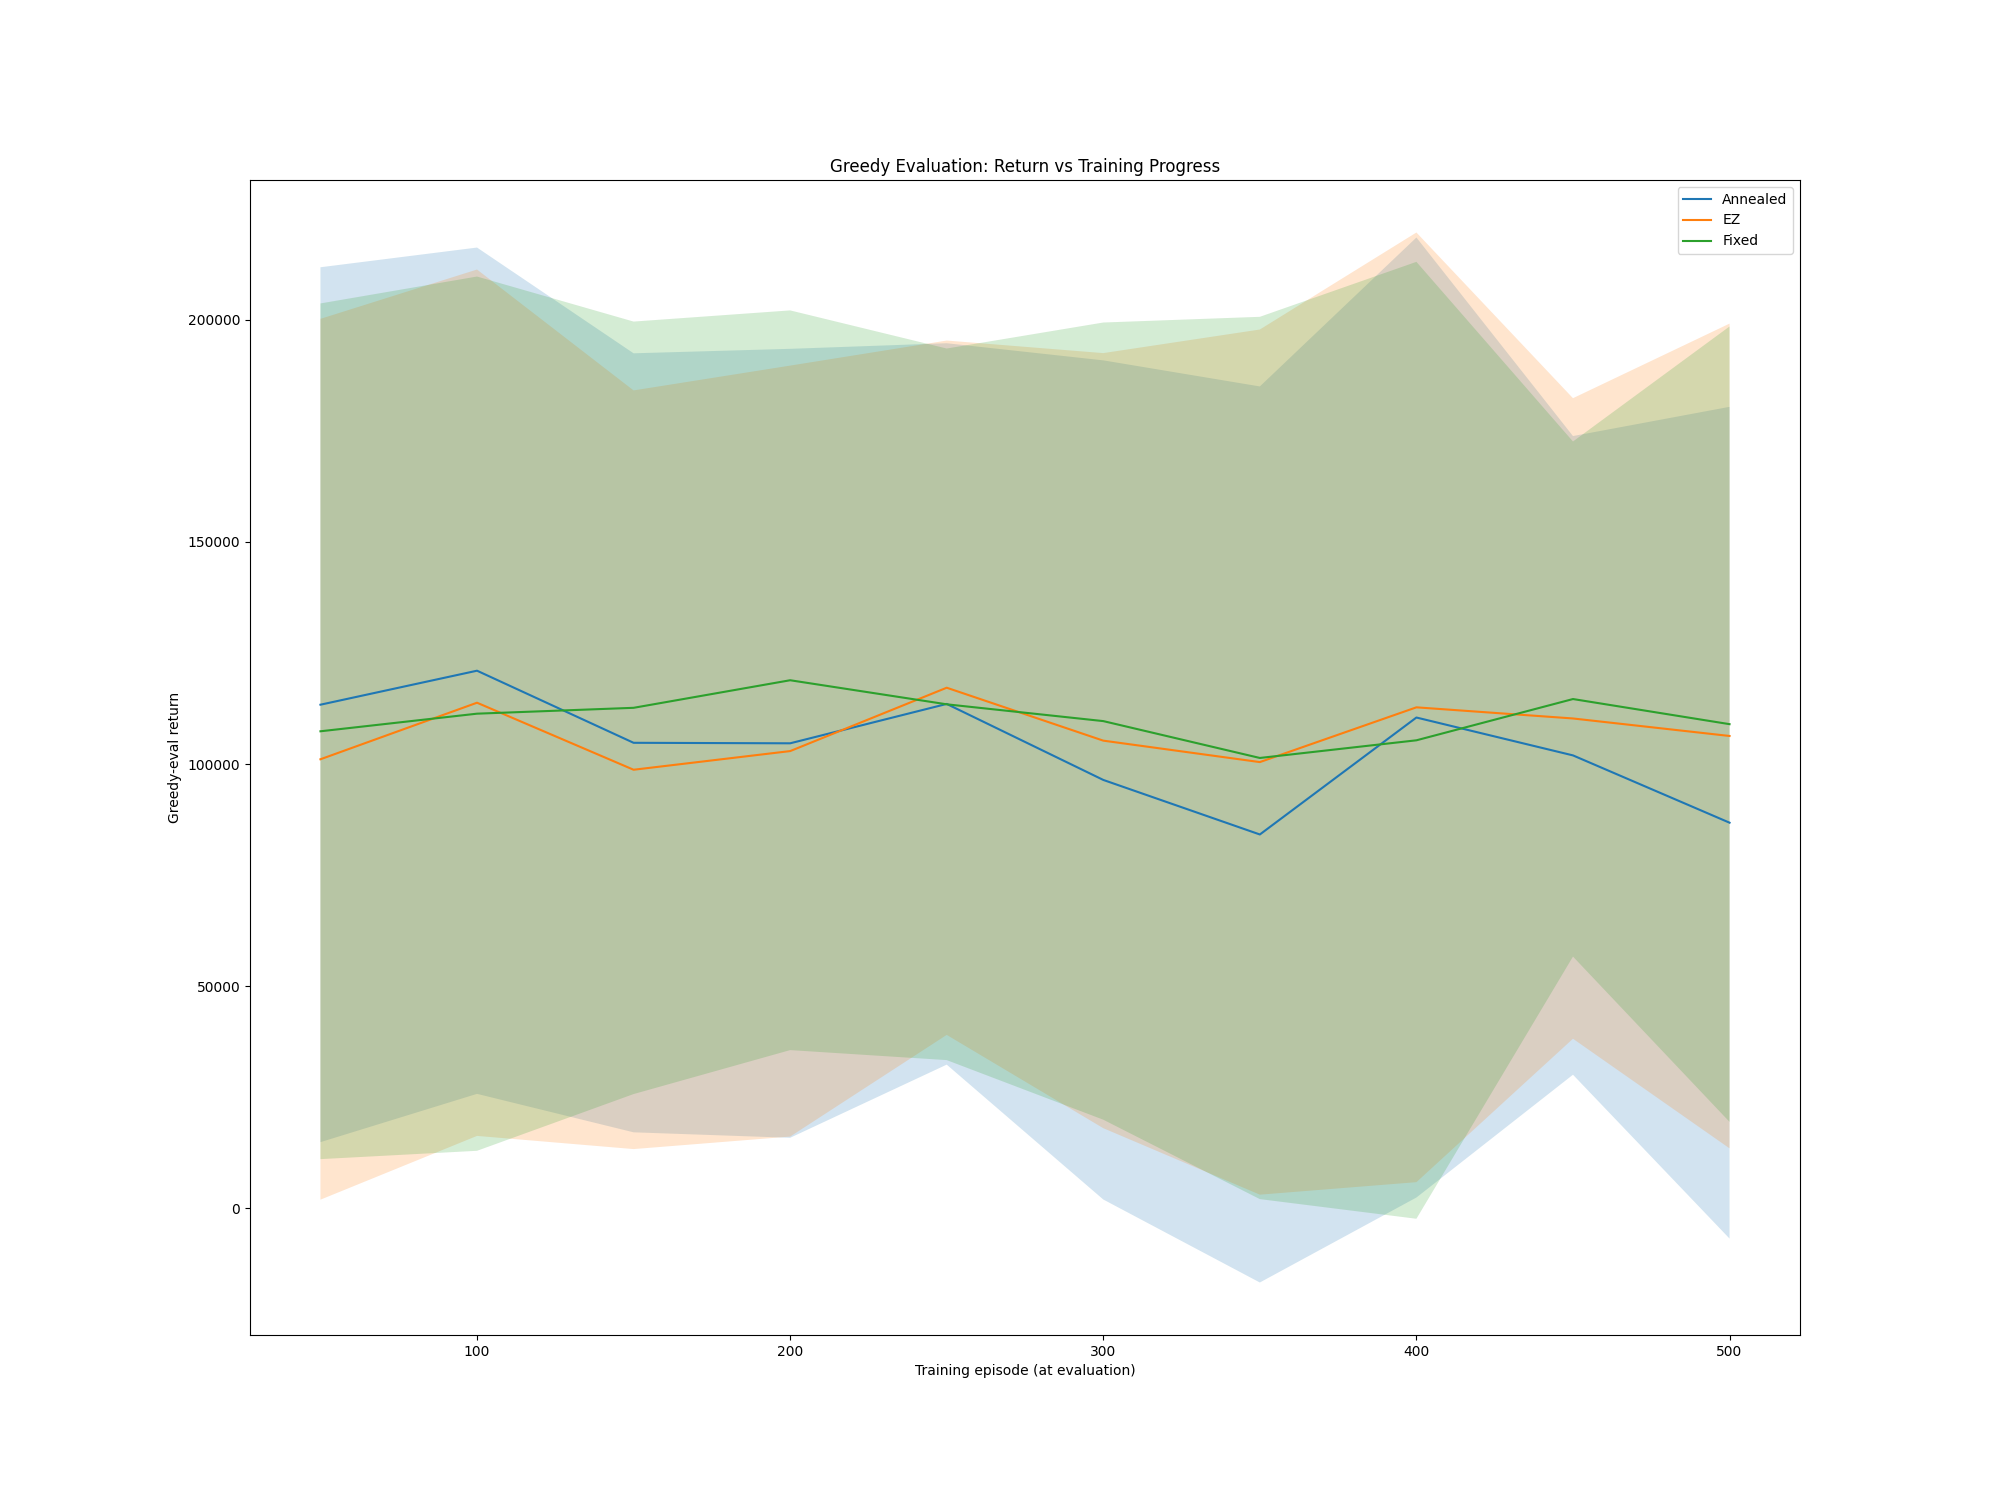

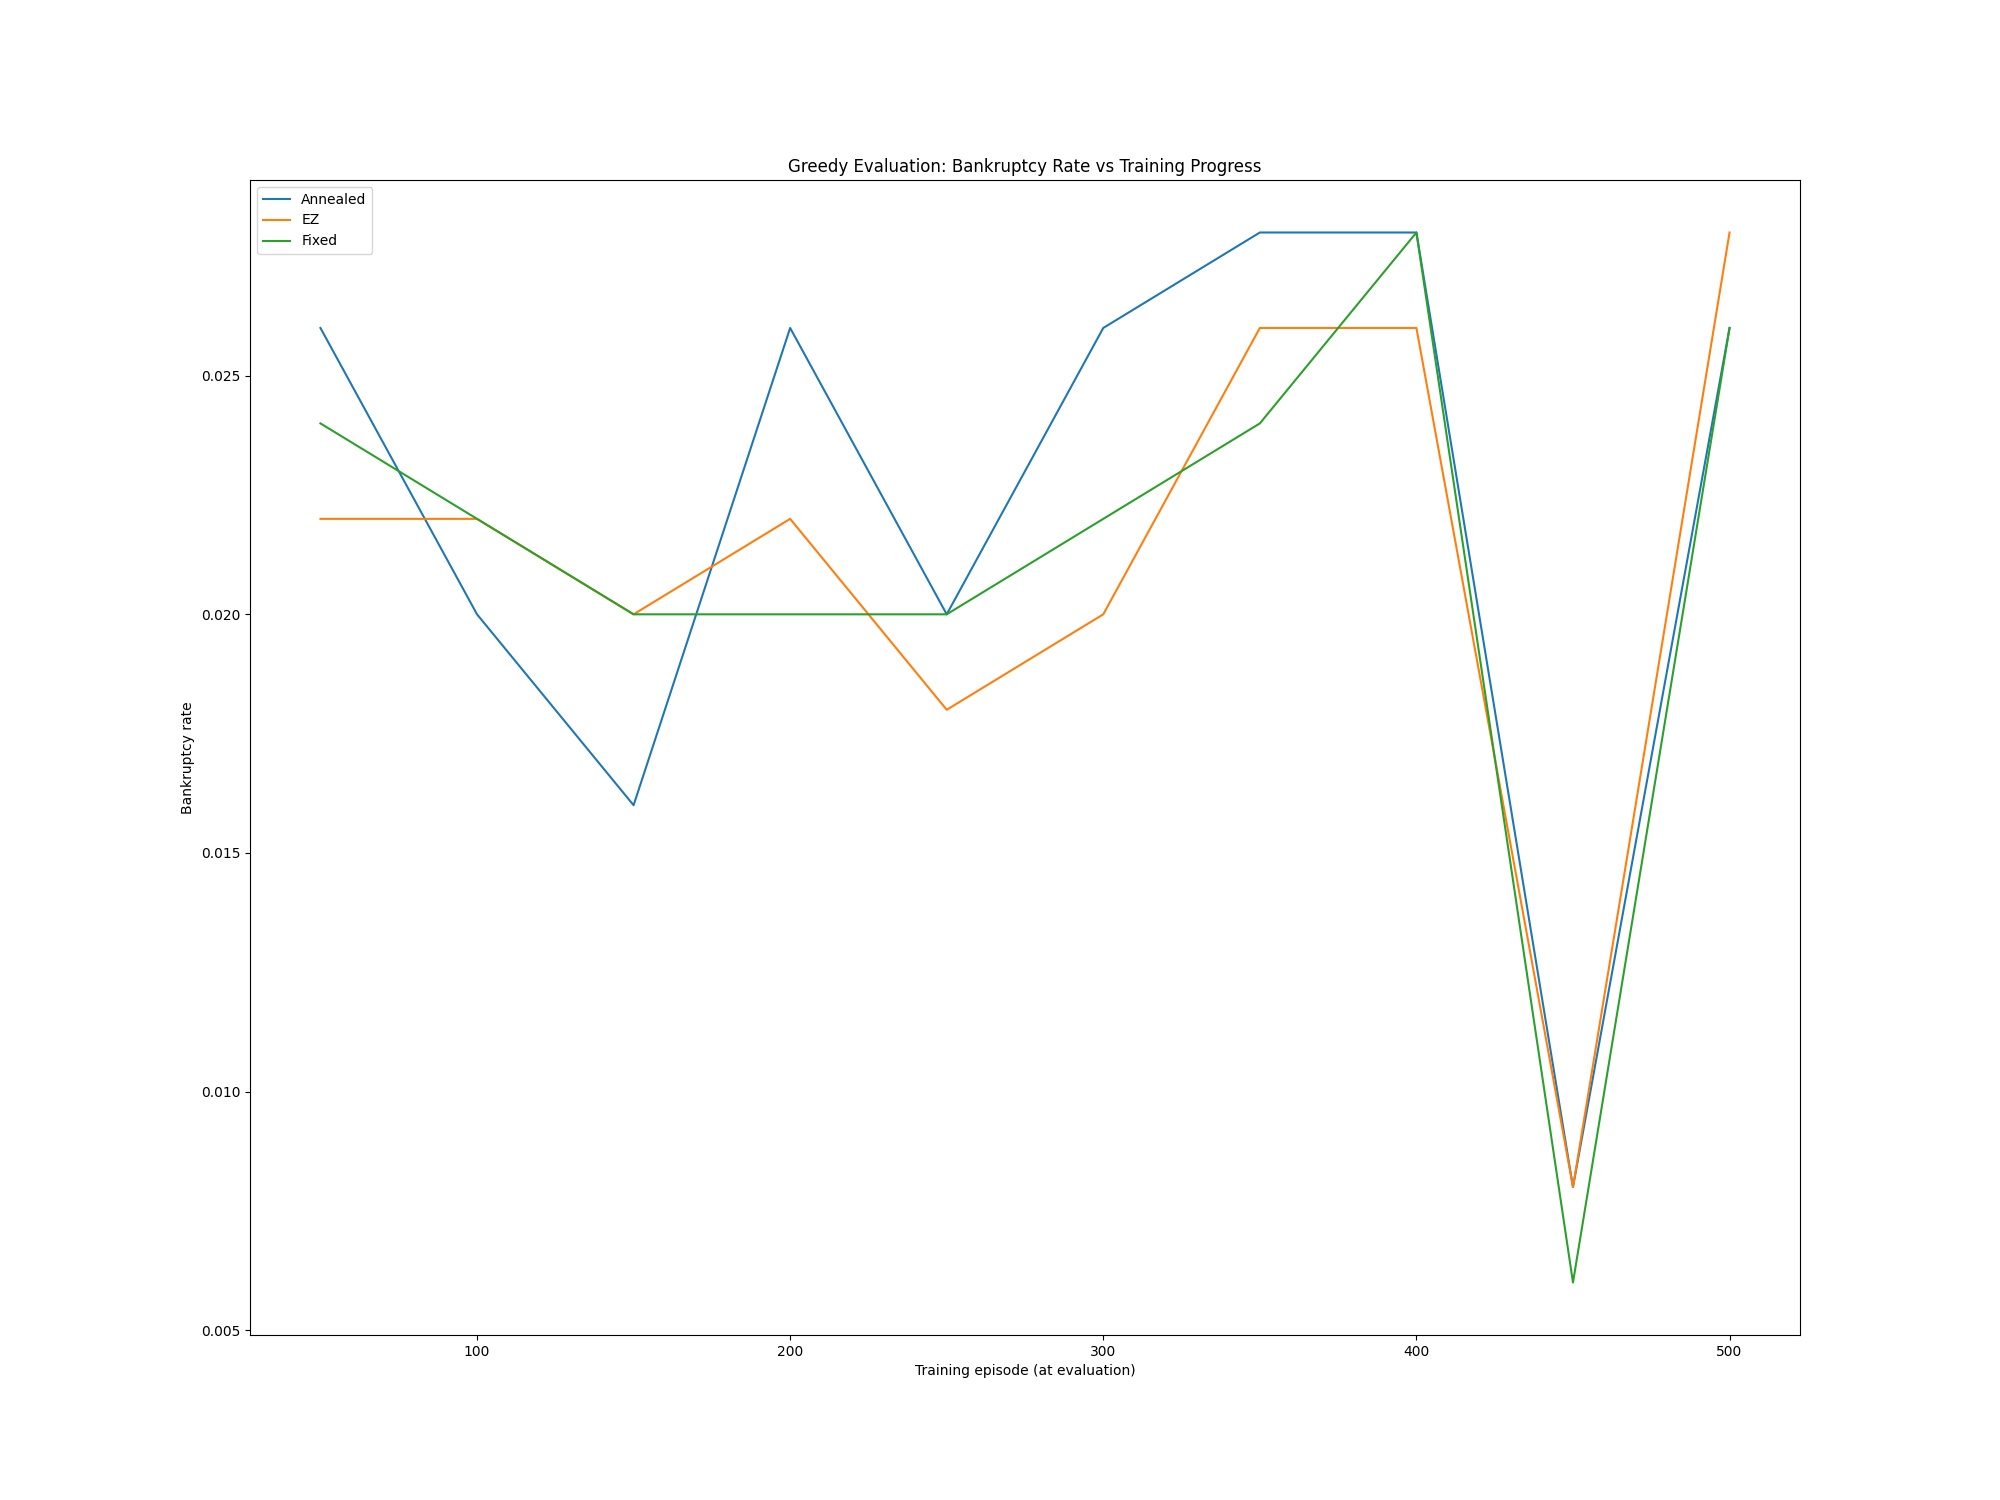

In [69]:

if eval_df.empty:
    print("No eval data found.")
else:
    fig = plt.figure(figsize=(20,15))
    ax = plt.gca()
    for v, g in eval_df.groupby("variant"):
        agg = g.groupby("block_episode")["return"].agg(["mean", "std"]).reset_index()
        ax.plot(agg["block_episode"], agg["mean"], label=v)
        ax.fill_between(agg["block_episode"], agg["mean"] - agg["std"], agg["mean"] + agg["std"], alpha=0.2)
    ax.set_xlabel("Training episode (at evaluation)")
    ax.set_ylabel("Greedy-eval return")
    ax.set_title("Greedy Evaluation: Return vs Training Progress")
    ax.legend()
    plt.show()

    fig = plt.figure(figsize=(20,15))
    ax = plt.gca()
    for v, g in eval_df.groupby("variant"):
        agg = g.groupby("block_episode")["bankrupt"].mean().reset_index()
        ax.plot(agg["block_episode"], agg["bankrupt"], label=v)
    ax.set_xlabel("Training episode (at evaluation)")
    ax.set_ylabel("Bankruptcy rate")
    ax.set_title("Greedy Evaluation: Bankruptcy Rate vs Training Progress")
    ax.legend()
    plt.show()


## Losses and claims

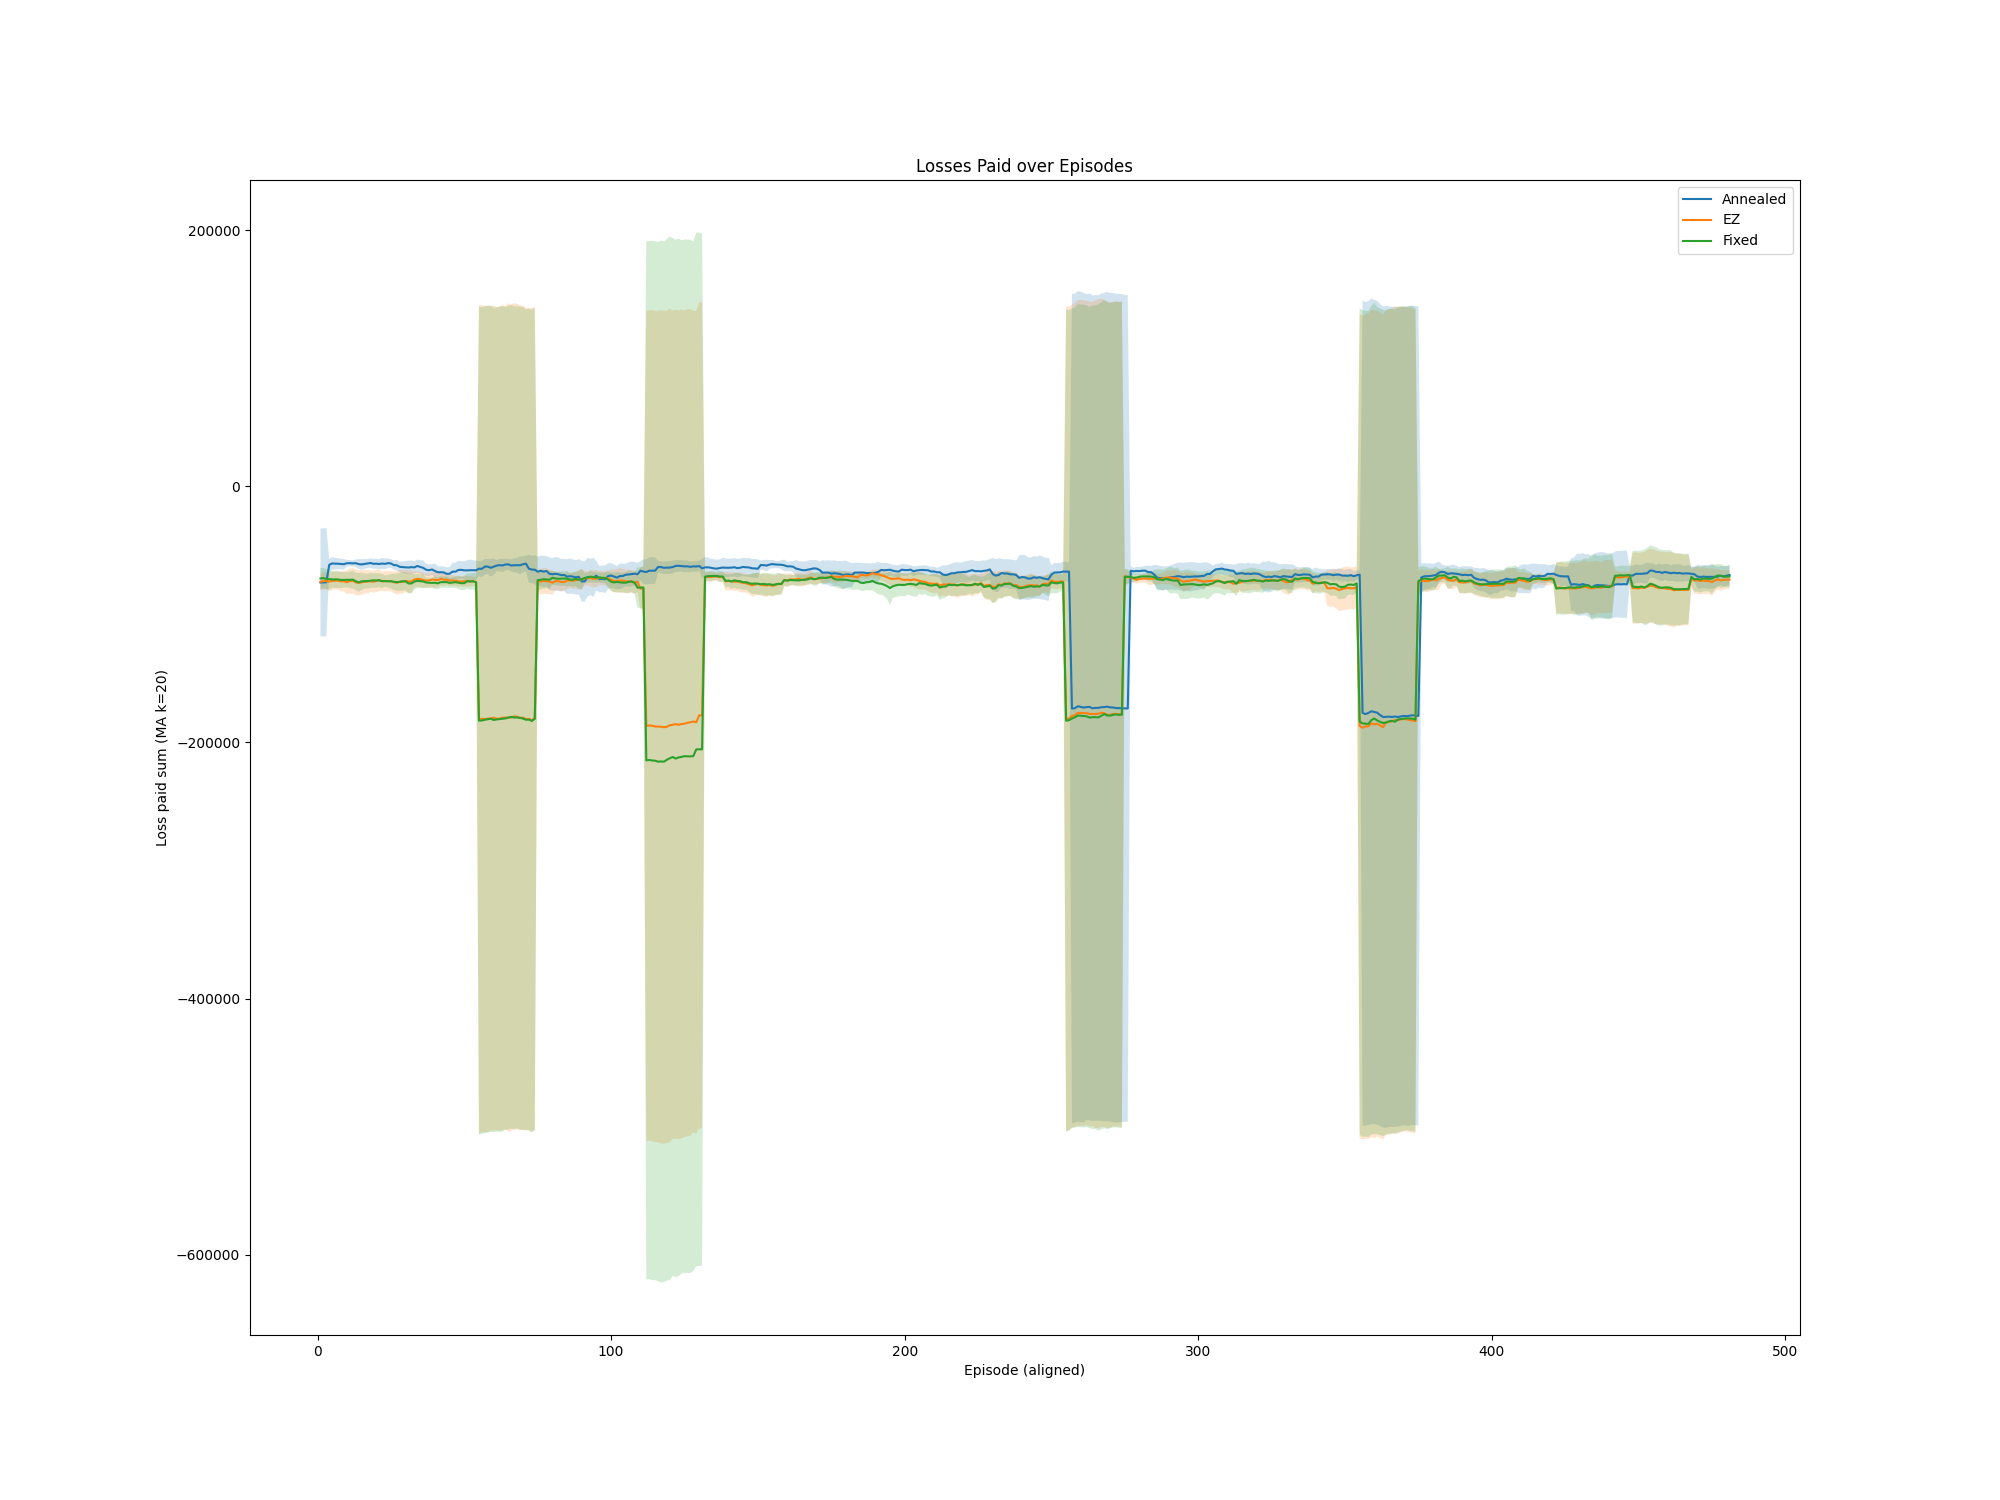

In [70]:

if train_df.empty:
    print("No training metrics found.")
else:
    fig = plt.figure(figsize=(20,15))
    ax = plt.gca()
    for v, g in train_df.groupby("variant"):
        x, ys = prepare_variant_series(g, value_col="loss_paid_sum", ma_k=20)
        if len(x) > 0 and ys:
            plot_mean_std(ax, x, ys, label=v)
    ax.set_xlabel("Episode (aligned)")
    ax.set_ylabel("Loss paid sum (MA k=20)")
    ax.set_title("Losses Paid over Episodes")
    ax.legend()
    plt.show()



## Summary table (last episode per seed)

In [71]:

if train_df.empty:
    print("No training metrics found.")
else:
    last_ep = train_df.groupby(["variant","seed"])["episode"].max().reset_index()
    merged = train_df.merge(last_ep, on=["variant","seed","episode"], how="inner")
    display_cols = ["variant","seed","return","final_capital","bankrupt","accept_rate","avg_premium"]
    display( merged[display_cols].sort_values(["variant","seed"]) )


variant  seed         return  final_capital  bankrupt  accept_rate  avg_premium
0   Annealed    10   99355.591590  149355.591590         0        0.944   390.832208
1   Annealed    11   96984.249170  146984.249170         0        0.996   376.346189
2   Annealed    12  130179.145010  180179.145010         0        0.932   391.555371
3   Annealed    13  119150.171022  169150.171022         0        0.990   366.090507
4   Annealed    14   77819.551428  127819.551428         0        0.576   401.586119
5   Annealed    15  108362.676056  158362.676056         0        0.848   387.022645
6   Annealed    16  141641.947526  191641.947526         0        0.996   391.175912
7   Annealed    17  138998.446195  188998.446195         0        0.952   404.241185
8   Annealed    18  134606.806263  184606.806263         0        0.928   407.318974
9   Annealed    19  110446.354214  160446.354214         0        0.990   378.555156
10        EZ    10  132562.310325  182562.310325         0        0.984   393.938218
11        EZ    11  132460.217110  182460.217110         0        0.984   391.782934
12        EZ    12  139931.979384  189931.979384         0        0.992   385.059684
13        EZ    13  129129.532461  179129.532461         0        0.976   391.200827
14        EZ    14  107223.143846  157223.143846         0        0.998   385.456518
15        EZ    15  120082.268462  170082.268462         0        0.984   393.526836
16        EZ    16   97370.228555  147370.228555         0        1.000   376.304004
17        EZ    17  120899.199755  170899.199755         0        0.948   414.768786
18        EZ    18  115431.960828  165431.960828         0        0.976   394.561481
19        EZ    19  112258.254543  162258.254543         0        0.942   397.069223
20     Fixed    10  136187.282698  186187.282698         0        0.984   389.127648
21     Fixed    11  129001.005130  179001.005130         0        0.986   391.015829
22     Fixed    12  139781.390915  189781.390915         0        0.984   387.861795
23     Fixed    13  116640.888812  166640.888812         0        0.988   373.957088
24     Fixed    14   95410.894240  145410.894240         0        0.778   387.071470
25     Fixed    15  116158.631686  166158.631686         0        0.990   388.825058
26     Fixed    16  127208.943979  177208.943979         0        0.972   402.107004
27     Fixed    17   93220.155221  143220.155221         0        0.976   398.248367
28     Fixed    18  109138.356783  159138.356783         0        0.990   387.038389
29     Fixed    19  119872.349491  169872.349491         0        0.994   389.005239